<a href="https://colab.research.google.com/github/amelmkdi/M2I2A-Advanced-Programming-Tools-for-AI/blob/main/Projet_Advanced_Programming_Tools_for_AI_Amel_MOKDADI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Projet Advanced Programming Tools for AI**
##**Détection de Fraude IEEE-CIS**
Réalisé par : Amel MOKDADI

#**Introduction**

La compétition IEEE Computational Intelligence Society (IEEE-CIS) de Kaggle est au centre
de ce projet. La tâche de cette compétition consiste à créer des modèles d'apprentissage
automatique pour prédire la probabilité qu'une transaction en ligne soit frauduleuse.
L’ensemble de données pour cette compétition est fourni par Vesta Corporation, une société
de services de paiement de premier plan, et contiennent un large éventail de fonctionnalités
allant du type d'appareil aux fonctionnalités du produit.
Le présent rapport s’articule sur le plan structuré de la façon suivante.

Dans la première section je fournis une brève description des données offertes par le distributeur et
les informations que j'ai obtenues après avoir fusionné les données.

Par la suite je présente l’analyse exploratoire que j'ai effectué sur les données
dans le but de comprendre chaque variable, son influence sur la cible, ainsi que découvrir
les effets croisés entre elles. En ce sens, la section suivante résume tous les traitements
que j'ai apportés sur les données, en se basant sur l’analyse exploratoire
précédente, notamment le traitement des données manquantes, aberrantes et la réduction
de dimensionnalité qui contribuent à l'accélération et la bonne construction du modèle.

Dans la dernière section, j'élabore la construction de modèles de classification et de régression à l’aide des algorithmes d’apprentissage automatique, à savoir les régressions linéaire, forêts aléatoires, SVR (Support Vector Regressor), ainsi que le KNN (K-Nearest Neighbors), et les réseaux de neurones récurrents (RNN) utilisant la méthode LSTM (Long Short-Term Memory).

J'applique également des techniques de prétraitement des données comme la normalisation et la gestion des déséquilibres de classes via la méthode SMOTE. Pour chaque modèle, j'évalue les performances en utilisant des métriques appropriées telles que le R2, l'erreur absolue moyenne (MAE), l'erreur quadratique moyenne (MSE) pour les régressions, ainsi que l'accuracy, le ROC AUC, et la matrice de confusion pour les modèles de classification.

### **Importation des librairies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
#from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample

%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split



#**Importation des données**
Les données sont téléchargées via le lien Kaggle : https://www.kaggle.com/datasets/lnasiri007/ieeecis-fraud-detection

In [3]:
# df_train_Tr=pd.read_csv("/content/drive/MyDrive/data/train_transaction.csv")
# df_train_identity=pd.read_csv("/content/drive/MyDrive/data/train_identity.csv")

In [4]:
# train= df_train_Tr.merge(df_train_identity, how='left', on="TransactionID")

In [5]:
# Sauvegarder le dataset train
# train.to_csv("/content/drive/MyDrive/data/train_fusionne.csv", index=False)

In [7]:
train=pd.read_csv("/content/drive/MyDrive/IA_AVANCEE/train_fusionne.csv")


## **Description des données**
Les données proviennent de transactions de commerce électronique réelles de la société
Vesta. Après avoir fusionné les ensembles de données (Transaction et Identity ) par une
jointure sur TransactionsID, on a obtenu un ensemble de données de train à grande
échelle à manipuler, qui contient 590540 lignes et 434 colonnes, et un ensemble de test de
506691 lignes et 433 colonnes.

1. Table d'identité (Informations sur les cartes et les détails du client):

- La table d'identité comprend 41 colonnes.
- Les variables de ce tableau sont les informations d'identité, les informations de connexion
au réseau (IP, FAI, Proxy, etc.) et la signature numérique (UA / navigateur / so / version,
etc.) associées aux transactions.

    - Identity- Variables catégorielles
      - Id12-id38
      - DeviceType
      - DeviceInfo
    - Identity-Variables numériques
      - TransactionID
      - Id1-id11.

2.  Table des transactions (Informations sur la transaction des clients)

La table des transactions comprend 394 colonnes.

- Transaction -Variables catégorielles
  - ProductCD
  - card1→card6
  - addr1, addr2
  - P_ et R _emaildomain
  - M1 →M9
- Transaction -Variables numériques
  - TransactionID
  - TransactionDT
  - TransactionAMT
  - dist1 and 2
  - D1→D15
  - Vxxx



In [8]:
print("The shape of train is: %s, %s" % (train.shape[0],train.shape[1]))


The shape of train is: 590540, 434


In [9]:
train.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000     214.000000     150.000000     166.000000   
50%      9678.000000     361.000000     150.000000     226.000000   
75%     14184.000000     512.000000     150.000000     226.000000   
max     18396.000000     600.000000     231.000000     237.000000   

               addr1          addr2  ...          id_17         id_18  \
count  524834.000000  524834.000000  ...  139369.000000  45113.000000   
mean      290.733794      86.800630  ...     189.451377     14.237337   
std       101.741072       2.690623  ...      30.375360      1.561302   
min       100.000000      10.000000  ...     100.000000     10.000000   
25%       204.000000      87.000000  ...     166.000000     13.000000   
50%       299.000000      87.000000  ...     166.000000     15.000000   
75%       330.000000      87.000000  ...     225.000000     15.000000   
max       540.000000     102.000000  ...     229.000000     29.000000   

               id_19          id_20        id_21        id_22        id_24  \
count  139318.000000  139261.000000  5159.000000  5169.000000  4747.000000   
mean      353.128174     403.882666   368.269820    16.002708    12.800927   
std       141.095343     152.160327   198.847038     6.897665     2.372447   
min       100.000000     100.000000   100.000000    10.000000    11.000000   
25%       266.000000     256.000000   252.000000    14.000000    11.000000   
50%       341.000000     472.000000   252.000000    14.000000    11.000000   
75%       427.000000     533.000000   486.500000    14.000000    15.000000   
max       671.000000     661.000000   854.000000    44.000000    26.000000   

             id_25        id_26         id_32  
count  5132.000000  5163.000000  77586.000000  
mean    329.608924   149.070308     26.508597  
std      97.461089    32.101995      3.737502  
min     100.000000   100.000000      0.000000  
25%     321.000000   119.000000     24.000000  
50%     321.000000   149.000000     24.000000  
75%     371.000000   169.000000     32.000000  
max     548.000000   216.000000     32.000000  

[8 rows x 403 columns]

Pour une compréhension approfondie nous passons à l’analyse exploratoire des données.
##**Analyse exploratoire des données**
Le but de cette analyse exploratoire n’est pas seulement de bien comprendre chaque
variable, mais aussi de découvrir les effets croisés entre elles. Par ailleurs, l’analyse que
j'ai réalisée comprend un grand nombre de graphiques et de tableaux statistiques,
je décide donc de ne présenter que certaines découvertes intéressantes dans ce
rapport.



###1. **Distribution cible(isFraud)**
Cette variable correspond à notre classe (data target) qui prend comme valeur 1 si la
transaction est frauduleuse, 0 sinon.

Comme le montre la FIGURE ci-dessous, la distribution cible est extrêmement
déséquilibrée; seulement 3,5% des transactions sont frauduleuses dans l'ensemble
d’apprentissage. Un ensemble de données déséquilibré amènera les algorithmes à obtenir
de bons résultats en renvoyant la classe majoritaire, qui ne permet pas de prédire les
données de test. Ce sera un problème, car on s'intéresse davantage à la classe
minoritaire.

Text(0, 0.5, 'Percentage')

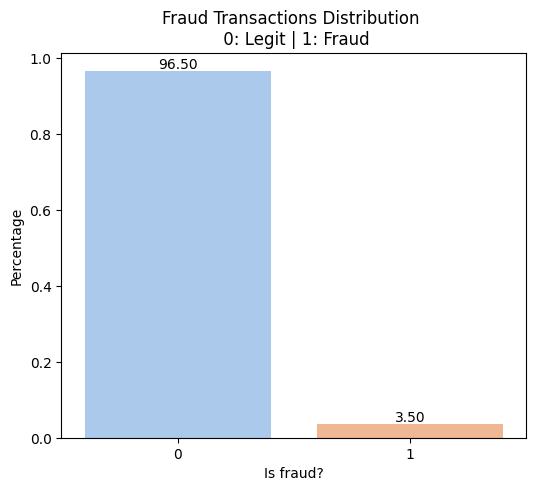

In [10]:
plt.figure(figsize=(6, 5))
yaxis = train['isFraud'].value_counts().values / train.shape[0]
barplot = sns.barplot(x=[0, 1], y=yaxis, hue=[0, 1], palette='pastel', legend=False)
for p in barplot.patches:
    barplot.annotate(format(p.get_height() * 100, '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 5), textcoords='offset points')
plt.title("Fraud Transactions Distribution \n 0: Legit | 1: Fraud")
plt.xlabel('Is fraud?')
plt.ylabel('Percentage')


On remarque que le taux des observations ayant comme étiquette **isFraud =0 est 96.5%**, tandis que celles qui ont l'étiquette **isFraud=1 est 3.53%**. On constate qu'on a un problème de classes non équilibrées.

### **TransactionDT - timedelta from a given reference datetime**
TransactionDT C'est l'une des fonctionnalités les plus importantes de notre ensemble de données. En traçant l'histogramme de TransactionDT des données de train.

La première valeur de TransactionDT est 86400, ce qui correspond au nombre de secondes dans une journée. Cela indique que l'unité de temps utilisée est la seconde. La durée totale couverte par ce jeu de données est donc de 6 mois, étant donné que la valeur maximale de TransactionDT est 15811131, correspondant à 183 jours.

In [ ]:
train['TransactionDT'].describe()

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
25%      3.027058e+06
50%      7.306528e+06
75%      1.124662e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

In [ ]:
train_span = (train['TransactionDT'].max() - train['TransactionDT'].min())/(3600*24)
print('Time span of Train dataset is {:.2f} days'.format(train_span))


Time span of Train dataset is 182.00 days


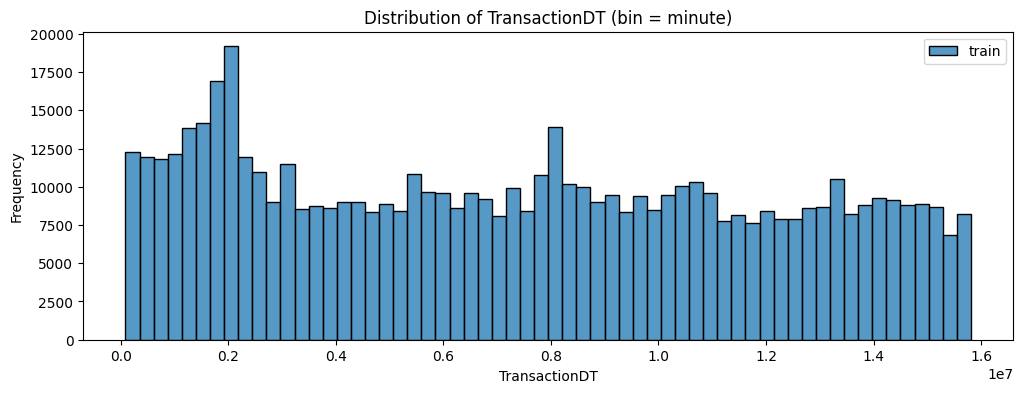

In [11]:
plt.figure(figsize=(12, 4))
sns.histplot(train['TransactionDT'], kde=False, bins=60)
plt.legend(['train'])
plt.ylabel('Frequency')
plt.title('Distribution of TransactionDT (bin = minute)')
plt.show()


Les données de train semblent être divisées en temps.
TransactionDT est une fonctionnalité de delta de temps donnée en secondes, donc sur la
base de cette fonctionnalité, j'ai créer une autre fonctionnalité nommée “hour”.

 **Créer une nouvelle fonctionnalité à partir de TransactionDT**

In [ ]:
train['hour'] = ((train['TransactionDT']//3600)%24)+1
train

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5  ... id_32      id_33  \
0       13926    NaN  150.0    discover  142.0  ...   NaN        NaN   
1        2755  404.0  150.0  mastercard  102.0  ...   NaN        NaN   
2        4663  490.0  150.0        visa  166.0  ...   NaN        NaN   
3       18132  567.0  150.0  mastercard  117.0  ...   NaN        NaN   
4        4497  514.0  150.0  mastercard  102.0  ...  32.0  2220x1080   
...       ...    ...    ...         ...    ...  ...   ...        ...   
590535   6550    NaN  150.0        visa  226.0  ...   NaN        NaN   
590536  10444  225.0  150.0  mastercard  224.0  ...   NaN        NaN   
590537  12037  595.0  150.0  mastercard  224.0  ...   NaN        NaN   
590538   7826  481.0  150.0  mastercard  224.0  ...   NaN        NaN   
590539  15066  170.0  150.0  mastercard  102.0  ...   NaN        NaN   

                 id_34  id_35  id_36 id_37 id_38  DeviceType  \
0                  NaN    NaN    NaN   NaN   NaN         NaN   
1                  NaN    NaN    NaN   NaN   NaN         NaN   
2                  NaN    NaN    NaN   NaN   NaN         NaN   
3                  NaN    NaN    NaN   NaN   NaN         NaN   
4       match_status:2      T      F     T     T      mobile   
...                ...    ...    ...   ...   ...         ...   
590535             NaN    NaN    NaN   NaN   NaN         NaN   
590536             NaN    NaN    NaN   NaN   NaN         NaN   
590537             NaN    NaN    NaN   NaN   NaN         NaN   
590538             NaN    NaN    NaN   NaN   NaN         NaN   
590539             NaN    NaN    NaN   NaN   NaN         NaN   

                           DeviceInfo  hour  
0                                 NaN     1  
1                                 NaN     1  
2                                 NaN     1  
3                                 NaN     1  
4       SAMSUNG SM-G892A Build/NRD90M     1  
...                               ...   ...  
590535                            NaN    24  
590536                            NaN    24  
590537                            NaN    24  
590538                            NaN    24  
590539                            NaN    24  

[590540 rows x 435 columns]

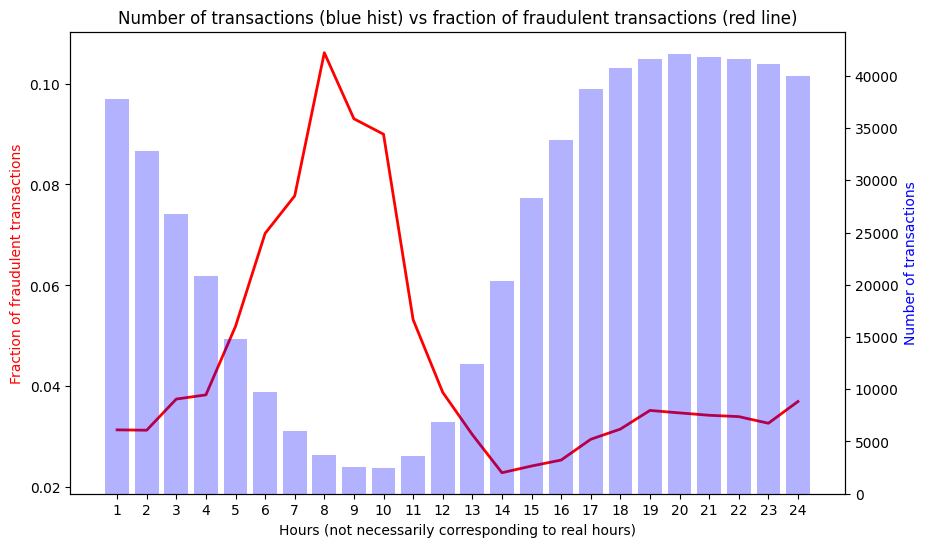

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
fraud_fraction = train.groupby('hour')['isFraud'].mean()
plt.plot(fraud_fraction, color='red', label="Fraction of fraudulent transactions", linewidth=2)
ax = plt.gca()
ax2 = ax.twinx()
transaction_counts = train['hour'].value_counts().sort_index()
ax2.bar(transaction_counts.index, transaction_counts.values, alpha=0.3, color='blue', label="Number of transactions", width=0.8)
ax.set_xlabel('Hours (not necessarily corresponding to real hours)')
ax.set_ylabel('Fraction of fraudulent transactions', color='red')
ax2.set_ylabel('Number of transactions', color='blue')
plt.title('Number of transactions (blue hist) vs fraction of fraudulent transactions (red line)', fontsize=12)
plt.xticks(np.arange(1, 25, 1))
plt.grid(visible=False)
plt.show()


On remarque que de 5h à 11h la fraction des fraud est plus élevée par rapport aux autres heures.



### **TransactionAmt**
C'est une autre caractéristique importante de notre ensemble de données. Cette colonne nous indique le montant de la transaction du client.


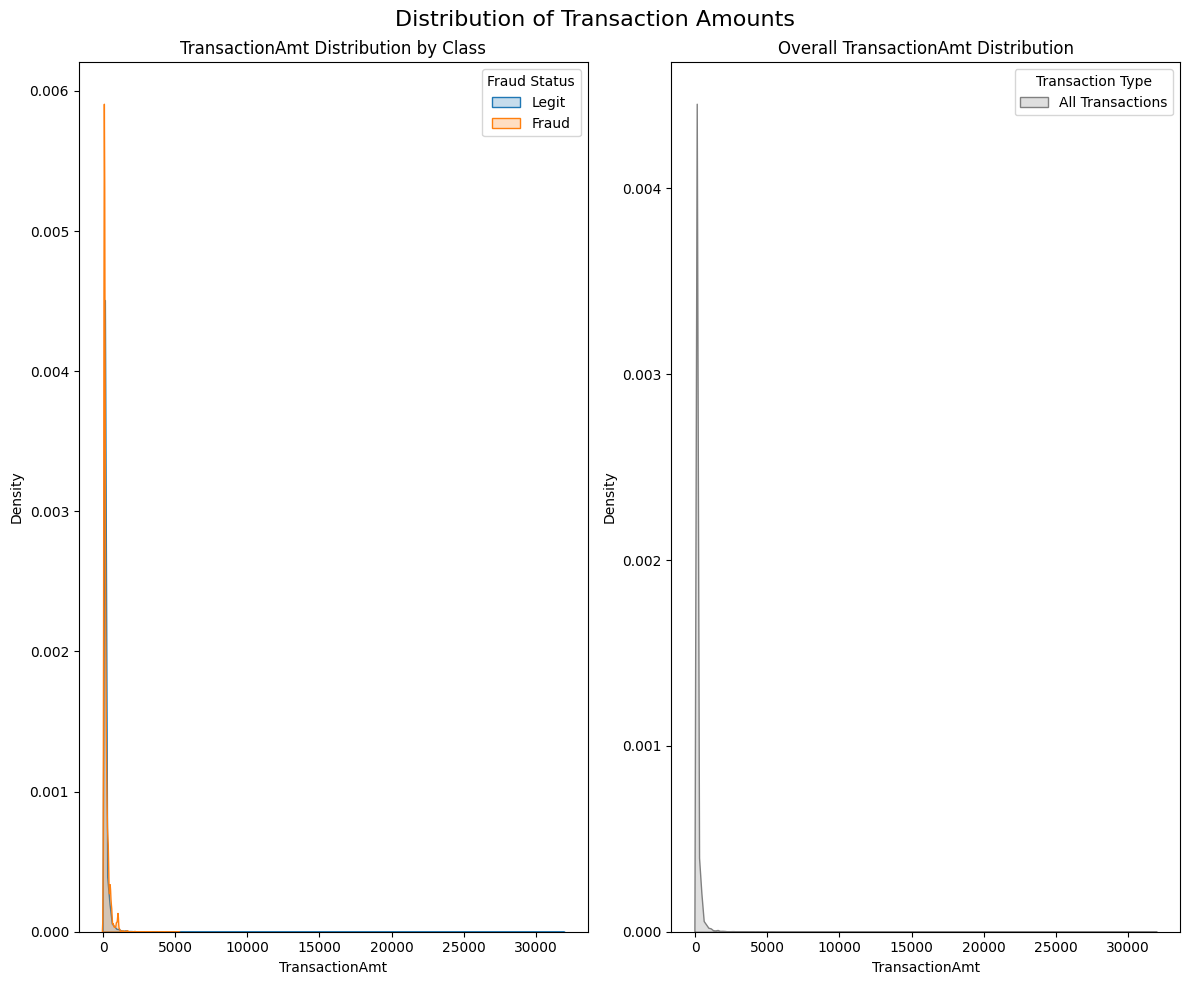

In [12]:
plt.figure(figsize=(12, 10))

# Premier sous-graphe : Distribution des montants pour les transactions légitimes et frauduleuses
plt.subplot(1, 2, 1)
sns.kdeplot(train[train['isFraud'] == 0]['TransactionAmt'], fill=True, label='Legit')  # Remplacer shade par fill=True
sns.kdeplot(train[train['isFraud'] == 1]['TransactionAmt'], fill=True, label='Fraud')  # Remplacer shade par fill=True
plt.xlabel('TransactionAmt')
plt.ylabel('Density')
plt.legend(title='Fraud Status')
plt.title('TransactionAmt Distribution by Class')

# Deuxième sous-graphe : Distribution globale des montants
plt.subplot(1, 2, 2)
sns.kdeplot(train['TransactionAmt'], fill=True, color='gray', label='All Transactions')  # Remplacer shade par fill=True
plt.xlabel('TransactionAmt')
plt.ylabel('Density')
plt.legend(title='Transaction Type')
plt.title('Overall TransactionAmt Distribution')

plt.suptitle('Distribution of Transaction Amounts', fontsize=16)

plt.tight_layout()
plt.show()


Plusieurs TansactionAmt  sont presque invisibles en raison du nombre important d'observation. on fait une visualisation pour le log(TransactionAmt) comme ça les valeurs les plus étndues de cette colonne vont se rapprocher,et on obtiendra une meilleure visualisation

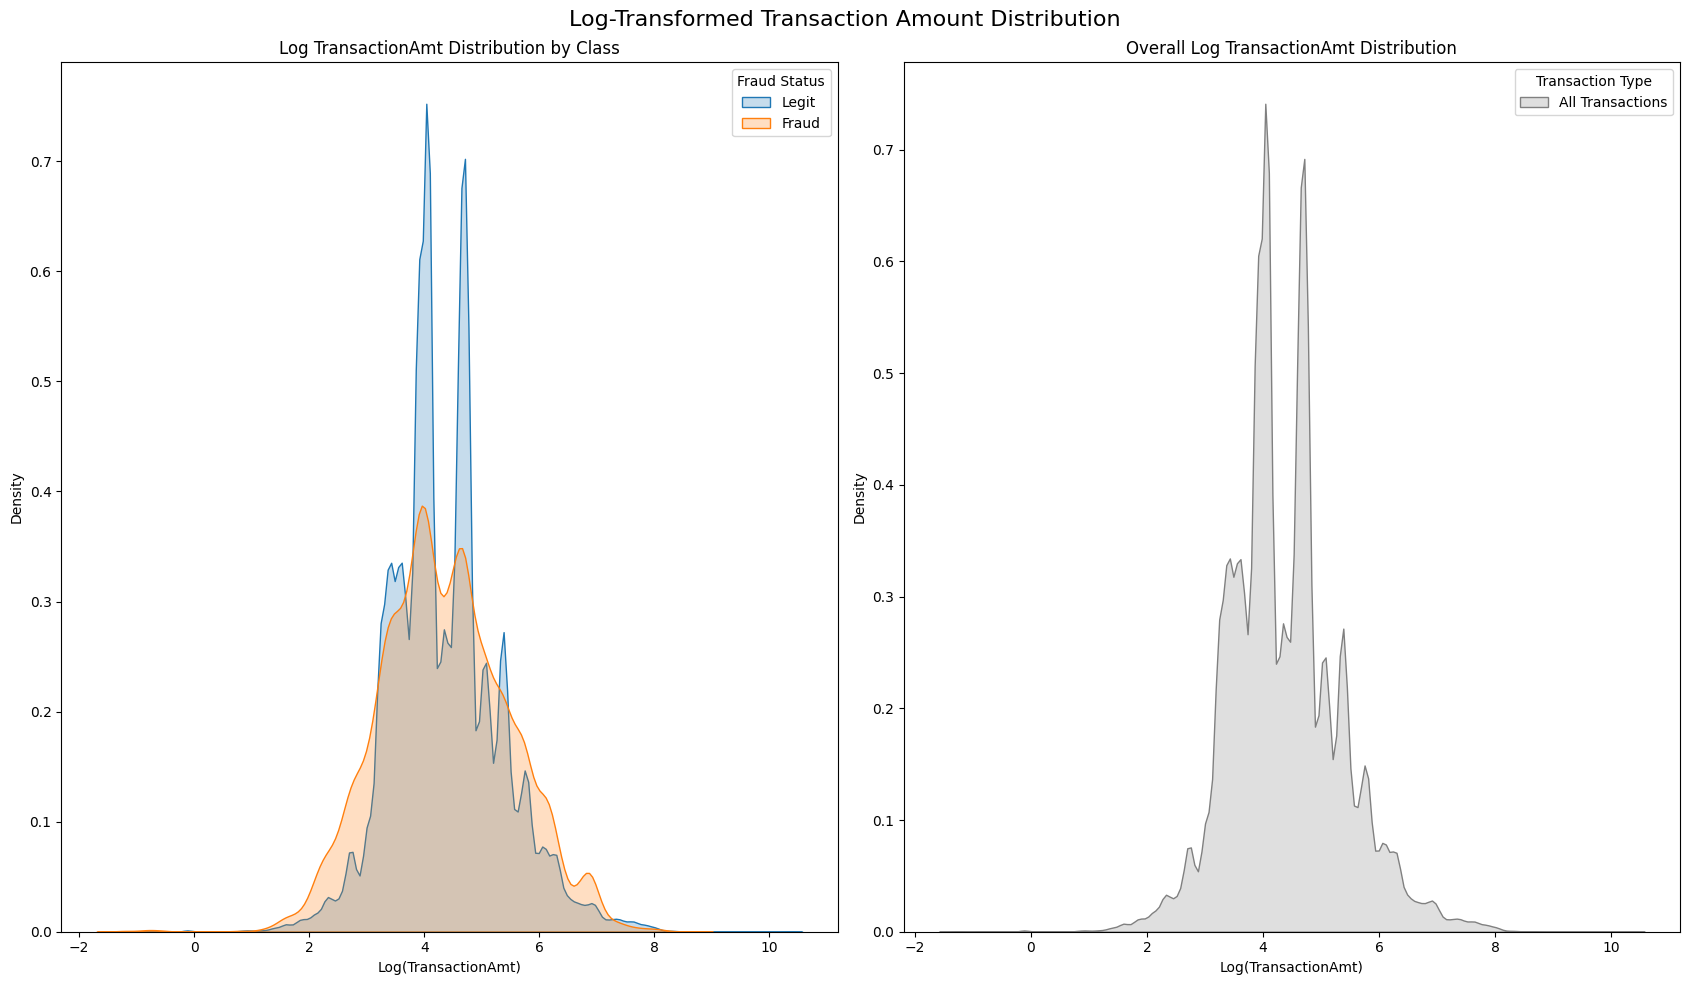

In [13]:
train['LogTransactionAmt'] = np.log(train['TransactionAmt'])

plt.figure(figsize=(17, 10))

# Premier sous-graphe : Distribution par classe
plt.subplot(1, 2, 1)
sns.kdeplot(train[train['isFraud'] == 0]['LogTransactionAmt'], fill=True, label='Legit')  # Remplacer shade par fill=True
sns.kdeplot(train[train['isFraud'] == 1]['LogTransactionAmt'], fill=True, label='Fraud')  # Remplacer shade par fill=True
plt.xlabel('Log(TransactionAmt)')
plt.ylabel('Density')
plt.legend(title='Fraud Status')
plt.title('Log TransactionAmt Distribution by Class')

# Deuxième sous-graphe : Distribution globale
plt.subplot(1, 2, 2)
sns.kdeplot(train['LogTransactionAmt'], fill=True, color='gray', label='All Transactions')  # Remplacer shade par fill=True
plt.xlabel('Log(TransactionAmt)')
plt.ylabel('Density')
plt.legend(title='Transaction Type')
plt.title('Overall Log TransactionAmt Distribution')

plt.suptitle('Log-Transformed Transaction Amount Distribution', fontsize=16)

plt.tight_layout()
plt.show()


Les LogTransactionAmt supérieurs à 5.5 (244 dollars) et ceux inférieurs à 3.3 (27 dollars) présentent une densité et une fréquence plus élevées et sont associées à des transactions frauduleuses. En revanche, les LogTransactionAmt situés dans l'intervalle [3.3;5.5] ont davantage de chances de correspondre à des transactions légitimes.

En observant le graphique ci-dessus, nous remarquons la présence de valeurs extrêmes des deux côtés, formant une longue queue de part et d’autre. Cela indique qu’il existe des valeurs aberrantes dans notre ensemble de données.

### **ProductCD**
Cette variable correspond au code du produit pour chaque transaction.
Cette colonne nous indique le produit pour lequel la transaction a lieu. Traçons un graphique
à barres pour vérifier le pourcentage de fraude par produit.

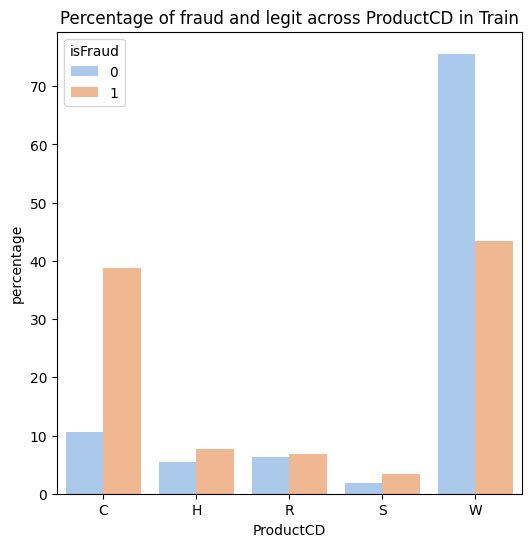

In [ ]:
plt.figure(figsize=(6,6))
train_ProductCD = (train.groupby(['isFraud'])['ProductCD'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('ProductCD'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=train_ProductCD,palette = 'pastel')
plt.title('Percentage of fraud and legit across ProductCD in Train')
plt.show()

On remarque que si une transaction est frauduleuse, il y a 40 % de chances qu'elle concerne le produit C. Étant donné que seulement 10 % des transactions légitimes impliquent le produit C, on peut raisonnablement supposer qu'une transaction liée à ce produit a une probabilité plus élevée d'être frauduleuse.

D’après le graphique ci-dessus, le produit C présente le plus grand nombre de cas de fraude. On peut donc en déduire que si une transaction concerne le produit C, il existe une forte probabilité qu'elle soit frauduleuse. Les produits H, R et S affichent également un nombre élevé de cas de fraude.

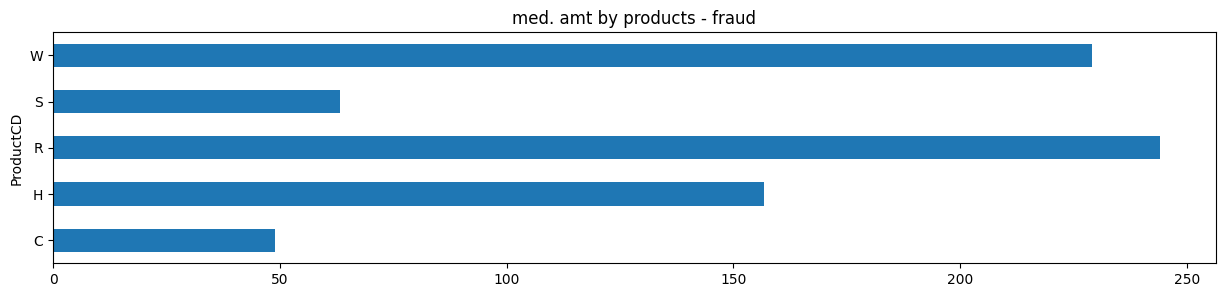

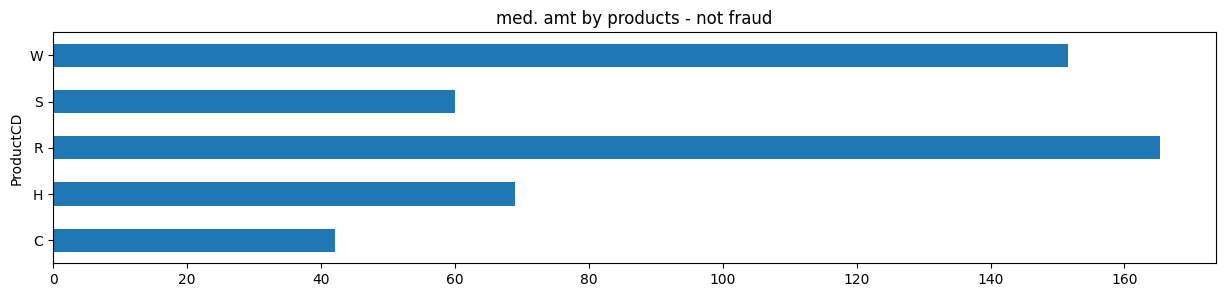

In [ ]:
train.loc[train['isFraud']==1]\
.groupby('ProductCD')['TransactionAmt'].mean().sort_index().plot(kind='barh',
                                                                 figsize=(15,3),
                                                                 title='med. amt by products - fraud')
plt.show()

train.loc[train['isFraud']==0]\
.groupby('ProductCD')['TransactionAmt'].mean().sort_index().plot(kind='barh',
                                                                 figsize=(15,3),
                                                                 title='med. amt by products - not fraud')
plt.show()

On remarque qu'il n'y a pas de relation entre le montant moyen d'un produit et la nature de la transaction. En effet, on observe le même montant moyen dans les transactions frauduleuses et dans celles légitimes.

### **Card1 - Card6**

Ces variables donnent des informations sur la carte du payement comme la catégorie de la
carte, le type, le pays, etc.
- Card1,card2,card3,card5 : des colonnes numériques
- Card 4, card 6 : des colonnes catégorielles
Dans cette partie nous nous intéressons aux card 3, 4 et 6.

**Card 1**

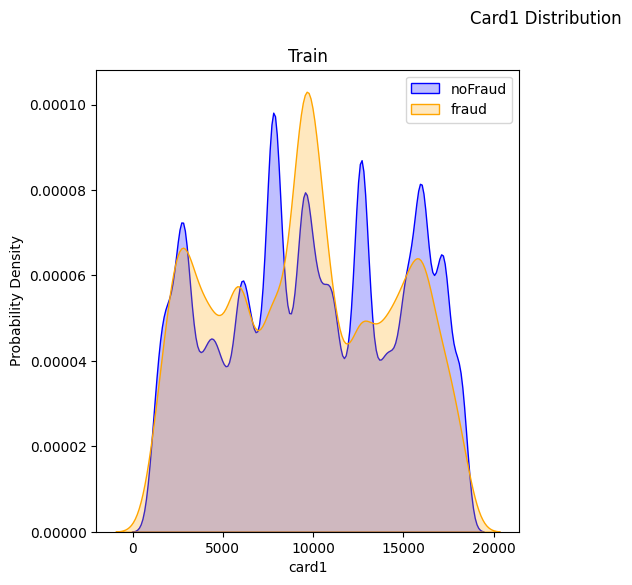

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(train[train['isFraud'] == 0]['card1'], fill=True, label='noFraud', color='blue')
sns.kdeplot(train[train['isFraud'] == 1]['card1'], fill=True, label='fraud', color='orange')
plt.ylabel('Probability Density')
plt.legend()
plt.suptitle('Card1 Distribution', fontsize=12)
plt.title('Train')
plt.show()


Comme on peut le voir, la colonne card1 est présentée comme une variable catégorielle, mais elle se comporte comme une donnée continue. Elle contient 13 553 valeurs uniques, ce qui pourrait indiquer qu'il s'agit d'une variable catégorielle codée. L'ensemble de données comporte de nombreuses variables à cardinalité élevée, ce qui rend leur modélisation complexe.

**card2**

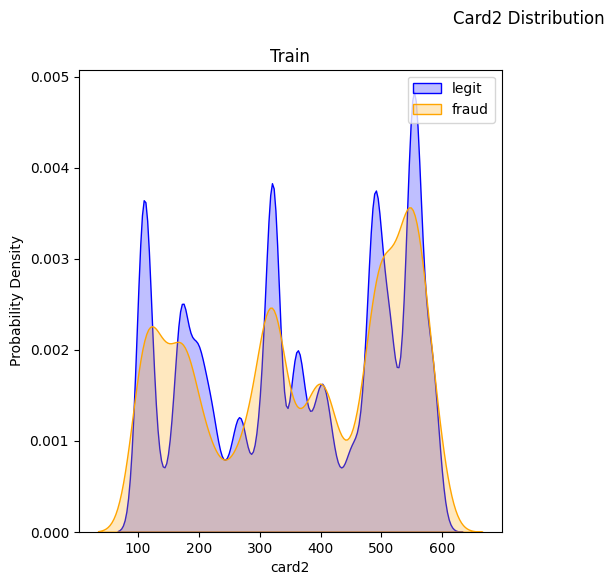

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(
    train[(train['isFraud'] == 0) & (~train['card2'].isnull())]['card2'],
    fill=True, label='legit', color='blue'
)
sns.kdeplot(
    train[(train['isFraud'] == 1) & (~train['card2'].isnull())]['card2'],
    fill=True, label='fraud', color='orange'
)

plt.ylabel('Probability Density')
plt.legend()
plt.title('Train')
plt.suptitle('Card2 Distribution', fontsize=12)
plt.show()


 Les transactions légitimes ont une distribution plus régulière, avec des pics à des intervalles spécifiques. Les transactions frauduleuses, en revanche, présentent des pics plus marqués et irréguliers, principalement entre 100 et 600. Cela suggère que les fraudes sont concentrées sur certaines plages de card2, ce qui mérite une analyse plus approfondie.

 **Card3** Cette colonne fournit des informations de carte de paiement masquées

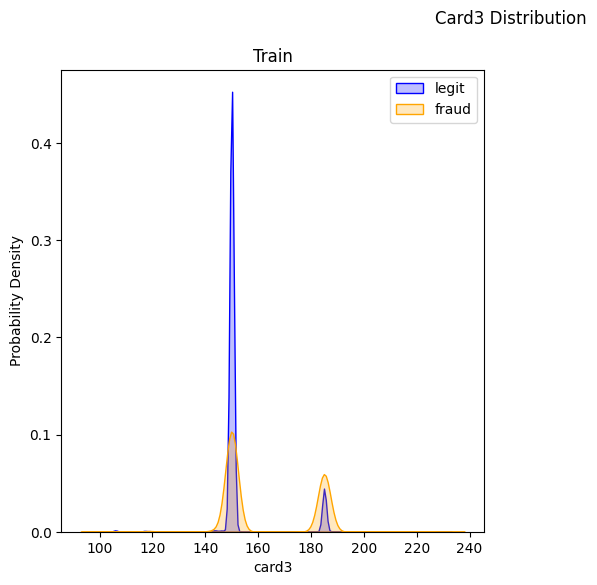

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(
    train[(train['isFraud'] == 0) & (~train['card3'].isnull())]['card3'],
    fill=True, label='legit', color='blue'
)
sns.kdeplot(
    train[(train['isFraud'] == 1) & (~train['card3'].isnull())]['card3'],
    fill=True, label='fraud', color='orange'
)
plt.ylabel('Probability Density')
plt.legend()
plt.title('Train')
plt.suptitle('Card3 Distribution', fontsize=12)
plt.show()


Nous remarquons que les valeurs autour de 150 ont plus de chances d'être légitimes; et les valeurs autour de 180 sont plus susceptibles d'être frauduleuses, je vais créer une nouvelle fonctionnalité qui catégorise card3:
- Si la valeur est supérieure à 160, alors «Positive».
- Sinon 'Négatif'

In [ ]:
def new_card3(row):
    if row==np.nan:
        return row
    else:
        if row > 160 :
            return 'Positive'
        else:
            return 'Negative'

train['card3'] = train['card3'].apply(new_card3)


In [ ]:
train.card3


0         Negative
1         Negative
2         Negative
3         Negative
4         Negative
            ...   
590535    Negative
590536    Negative
590537    Negative
590538    Negative
590539    Negative
Name: card3, Length: 590540, dtype: object

**card4** Cette colonne fournit des informations sur le nom de la carte de l'entreprise

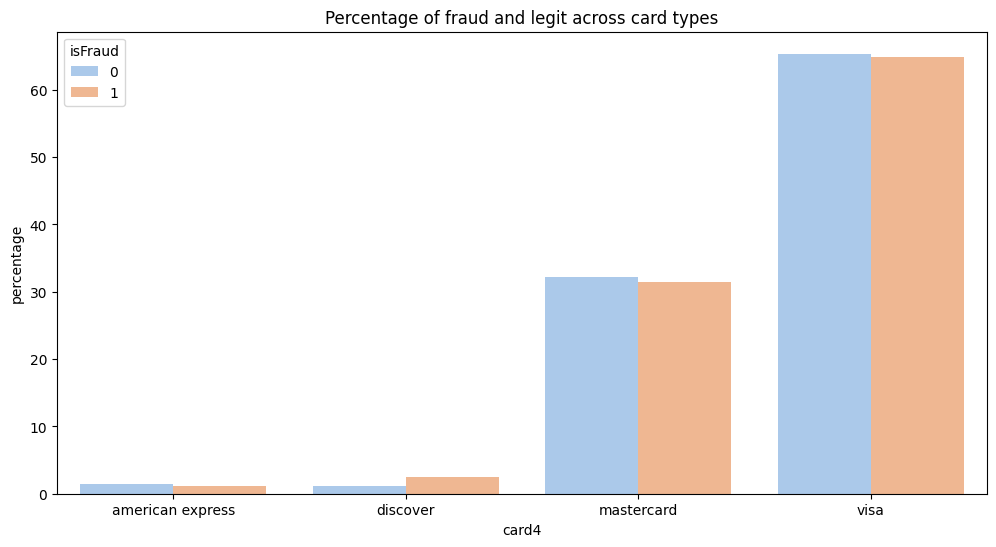

In [ ]:
plt.figure(figsize=(12,6))
train_card4 = (train[~train['card4'].isnull()].groupby(['isFraud'])['card4'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card4'))
sns.barplot(x="card4", y="percentage", hue="isFraud", data=train_card4, palette = 'pastel')
plt.title('Percentage of fraud and legit across card types')
plt.show()

La plupart des transactions sont effectuées avec des cartes de type Visa et Mastercard. Cependant, il est difficile de tirer des conclusions sur le type de carte le plus utilisé pour les transactions frauduleuses, car les pourcentages d'utilisation sont similaires pour les transactions frauduleuses et non frauduleuses. En résumé, on remarque que Visa et Mastercard sont les types de cartes les plus utilisés pour les transactions.

**card5**

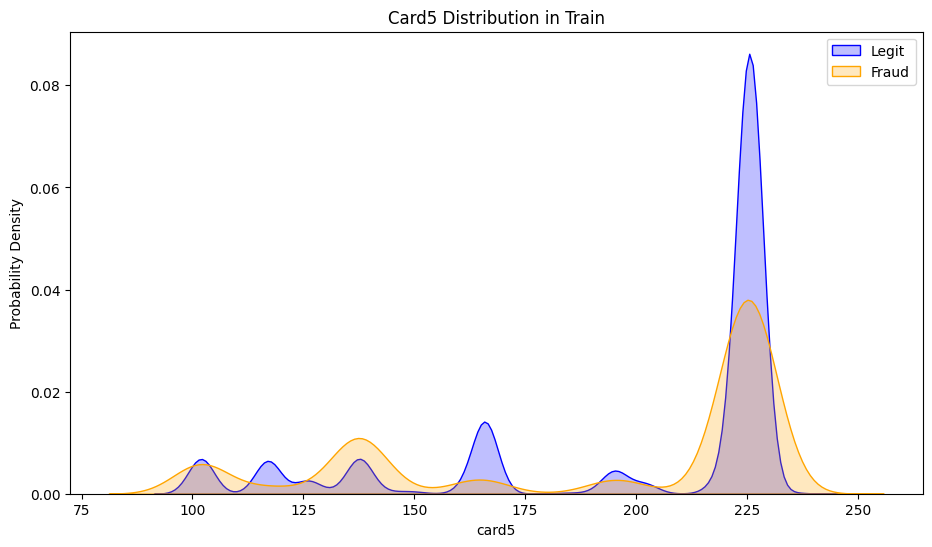

In [17]:
plt.figure(figsize=(11, 6))
sns.kdeplot(
    train[(train['isFraud'] == 0) & (~train['card5'].isnull())]['card5'],
    fill=True, label='Legit', color='blue'
)
sns.kdeplot(
    train[(train['isFraud'] == 1) & (~train['card5'].isnull())]['card5'],
    fill=True, label='Fraud', color='orange'
)
plt.legend()
plt.ylabel('Probability Density')
plt.title('Card5 Distribution in Train')
plt.show()


Les transactions frauduleuses, en revanche, ont une distribution plus étalée et moins concentrée. Le pic à 225 est beaucoup plus prononcé dans les transactions légitimes que dans les frauduleuses. Cela suggère que les transactions légitimes sont plus fréquentes à cette valeur, tandis que les transactions frauduleuses suivent un comportement différent.

**card6** Cette colonne fournit des informations sur le type de carte et nous indique si la transaction a été effectuée par carte de crédit, débit ou de paiement.

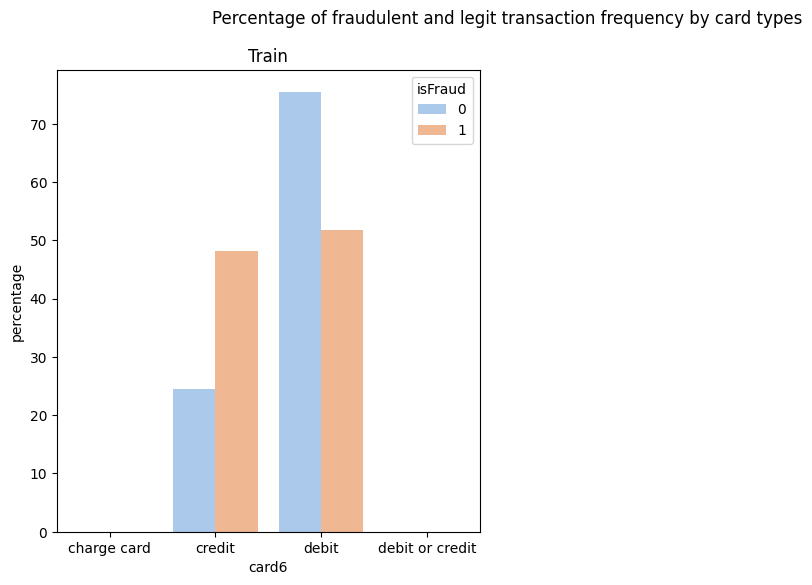

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train_card6 = (
    train[~train['card6'].isnull()]
    .groupby(['isFraud'])['card6']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
    .sort_values('card6')
)
sns.barplot(x="card6", y="percentage", hue="isFraud", data=train_card6, palette='pastel')
plt.title('Train')

plt.xlabel('card6')

plt.suptitle('Percentage of fraudulent and legit transaction frequency by card types', fontsize=12)
plt.show()


On remarque que le pourcentage d'observations avec card6 = "charge card" est négligeable dans l'ensemble d'apprentissage. Il en va de même pour le taux d'observations avec card6 = "debit or credit", qui est nul dans l'ensemble d'apprentissage. Par conséquent, on peut remplacer ces observations par "debit"

In [ ]:
print('%d observations are charge card' % train[train['card6']=='charge card'].shape[0])
print('%d observations are debit or credit card' % train[train['card6']=='debit or credit'].shape[0])

15 observations are charge card
30 observations are debit or credit card


Dans la variable card6, il y a seulement 15 observations correspondant à "charge card" et 30 observations correspondant à "debit or credit" dans l'ensemble d'entraînement. Comme la taille de l'échantillon est insuffisante pour établir un modèle général et que le type majoritaire de card6 est "débit", nous pouvons remplacer ces observations par le type "débit".

In [ ]:
def replacetodebit(row):
    if row==np.nan:
        return row
    if row=='debit or credit' or row=='charge card':
        return 'debit'
    else:
        return row

train['card6'] = train['card6'].apply(replacetodebit)


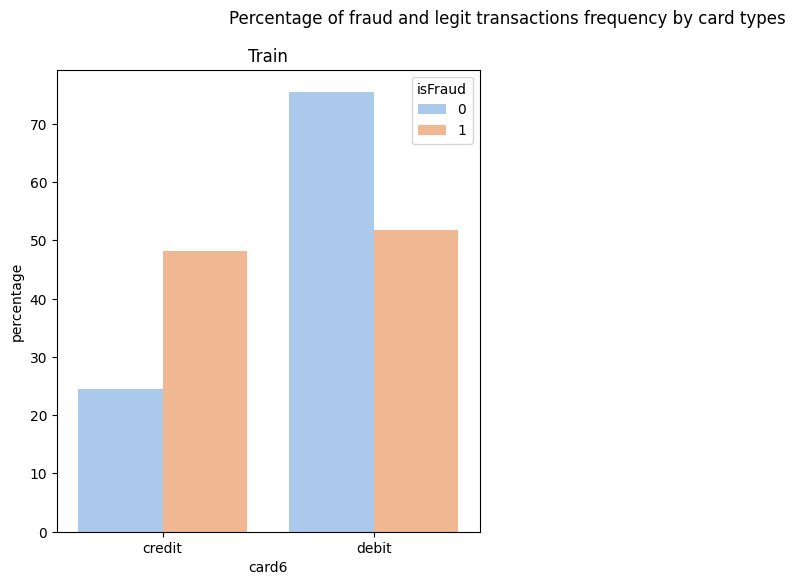

In [ ]:
plt.figure(figsize=(12, 6))

# Sous-graphe 1 : Train
plt.subplot(1, 2, 1)
train_card6 = (
    train[~train['card6'].isnull()]
    .groupby(['isFraud'])['card6']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
    .sort_values('card6')
)
sns.barplot(x="card6", y="percentage", hue="isFraud", data=train_card6, palette='pastel')
plt.title('Train')

plt.suptitle('Percentage of fraud and legit transactions frequency by card types', fontsize=12)
plt.show()


### **Addr1- Addr2**

In [ ]:
print('There are %d regions in addr1 of Train' % len(train['addr1'].value_counts()))

print('There are %d billing countries in addr2 of Train' % len(train['addr2'].value_counts()))


There are 332 regions in addr1 of Train
There are 74 billing countries in addr2 of Train


On remarque qu'il y a 332 régions dans addr1 et 74 pays de facturation dans addr2, ce qui montre une grande diversité géographique dans les données d'entraînement.

### **dist1**

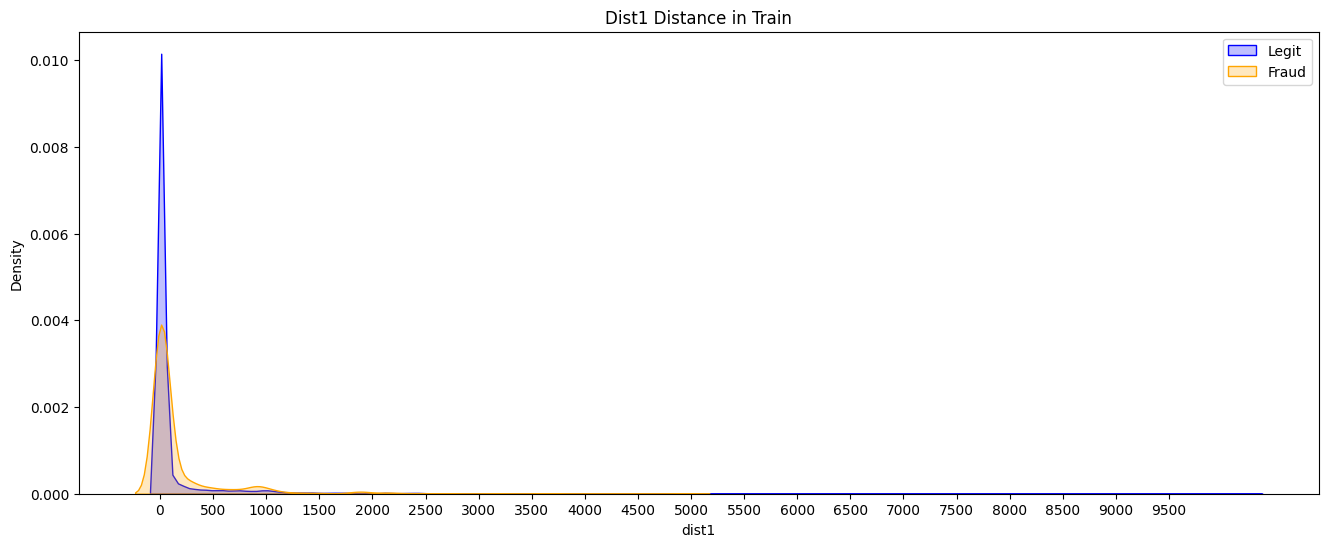

In [18]:
plt.figure(figsize=(16, 6))

sns.kdeplot(
    train[(train['isFraud'] == 0) & (~train['dist1'].isnull())]['dist1'],
    fill=True, label='Legit', color='blue'
)
sns.kdeplot(
    train[(train['isFraud'] == 1) & (~train['dist1'].isnull())]['dist1'],
    fill=True, label='Fraud', color='orange'
)

plt.legend()
plt.xticks(np.arange(0, 10000, 500))
plt.title('Dist1 Distance in Train')
plt.show()


On remarque que les transactions frauduleuses ont une dist1 moyenne plus élevée que les transactions légitimes. On peut conclure que les fraudeurs commettent généralement des fraudes à une distance relativement plus grande de l'adresse du titulaire de la carte.

### **dist2**

In [ ]:
print( (train["dist2"].isnull().sum().sum() / train.shape[0])*100 )


93.62837403054831


On remarque que le taux de données manquantes est très élevé dans cette colonne.

*Conclusion :* Cette colonne n'apporte pas d'informations et sera supprimée lors de la phase de traitement des données manquantes.

### **P_emaildomain R_emaildomain**
Ces variables correspondent aux adresses mail des acheteurs et des destinataires
respectivement

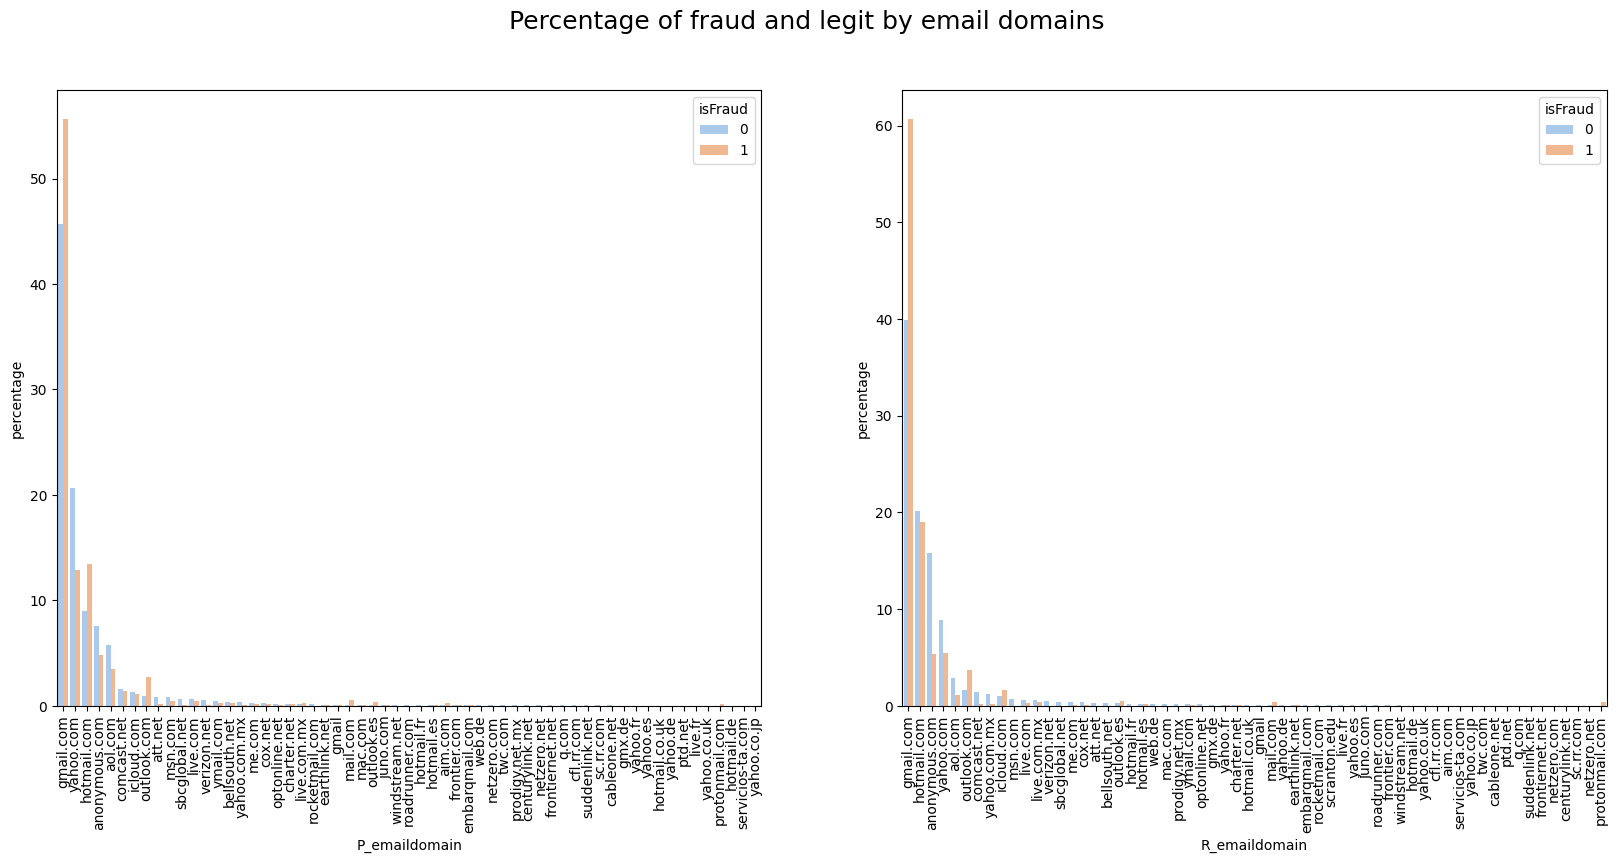

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
train_P_email = (train[~train['P_emaildomain'].isnull()].groupby(['isFraud'])['P_emaildomain'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(x="P_emaildomain", y="percentage", hue="isFraud", data=train_P_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
train_R_email = train[~train['R_emaildomain'].isnull()].groupby(['isFraud'])['R_emaildomain'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="R_emaildomain", y="percentage", hue="isFraud", data=train_R_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.suptitle('Percentage of fraud and legit by email domains', fontsize=18)
plt.show()

On regroupe les domaines d'email par entreprise, et ceux ayant moins de 500 observations sont classés comme "autres". Les valeurs NaN sont remplacées par NoInfo, car aucune autre colonne ne permet de prédire les données manquantes. Nous pouvons envisager, dans la section suivante, de regrouper les domaines d'email par entreprise, et de classer ceux ayant moins de 500 observations comme "autres".

In [20]:
# Regroupement et simplification des domaines pour P_emaildomain
train['P_emaildomain'] = train['P_emaildomain'].replace(
    ['gmail.com', 'gmail'], 'Google'
)
train['P_emaildomain'] = train['P_emaildomain'].replace(
    ['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp',
     'yahoo.de', 'yahoo.fr', 'yahoo.es'], 'Yahoo'
)
train['P_emaildomain'] = train['P_emaildomain'].replace(
    ['hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx',
     'hotmail.es', 'hotmail.co.uk', 'hotmail.de', 'outlook.es',
     'live.com', 'live.fr', 'hotmail.fr'], 'Microsoft'
)
train['P_emaildomain'] = train['P_emaildomain'].where(
    train['P_emaildomain'].isin(
        ['Google', 'Yahoo', 'Microsoft']
    ), "Others"
)
train['P_emaildomain'] = train['P_emaildomain'].fillna("NoInf")

# Regroupement et simplification des domaines pour R_emaildomain
train['R_emaildomain'] = train['R_emaildomain'].replace(
    ['gmail.com', 'gmail'], 'Google'
)
train['R_emaildomain'] = train['R_emaildomain'].replace(
    ['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp',
     'yahoo.de', 'yahoo.fr', 'yahoo.es'], 'Yahoo'
)
train['R_emaildomain'] = train['R_emaildomain'].replace(
    ['hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx',
     'hotmail.es', 'hotmail.co.uk', 'hotmail.de', 'outlook.es',
     'live.com', 'live.fr', 'hotmail.fr'], 'Microsoft'
)
train['R_emaildomain'] = train['R_emaildomain'].where(
    train['R_emaildomain'].isin(
        ['Google', 'Yahoo', 'Microsoft']
    ), "Others"
)
train['R_emaildomain'] = train['R_emaildomain'].fillna("NoInf")


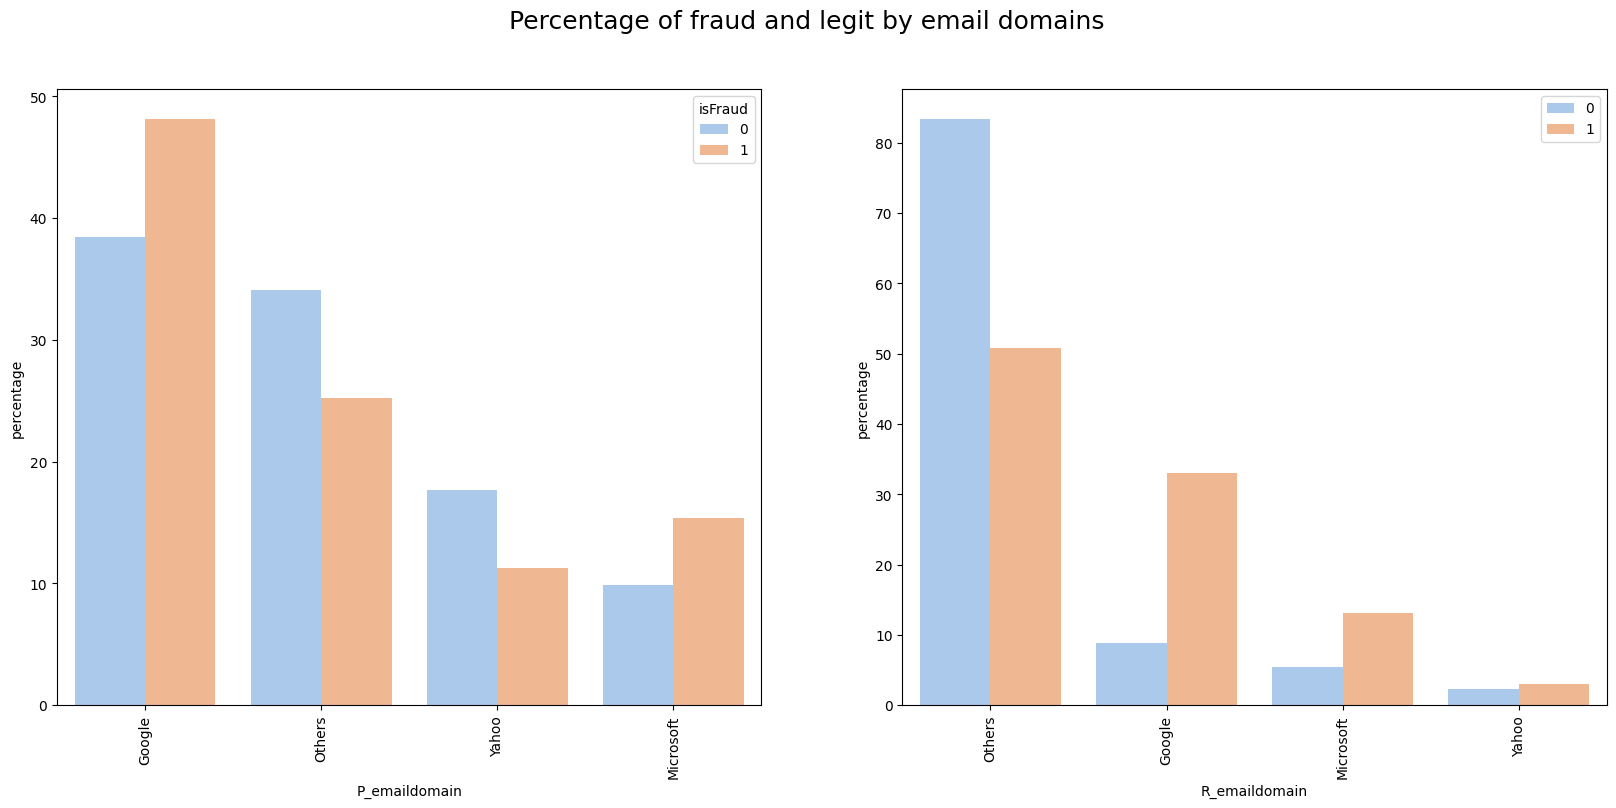

In [21]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
train_P_email = (train[~train['P_emaildomain'].isnull()].groupby(['isFraud'])['P_emaildomain'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(x="P_emaildomain", y="percentage", hue="isFraud", data=train_P_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
train_R_email = train[~train['R_emaildomain'].isnull()].groupby(['isFraud'])['R_emaildomain'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="R_emaildomain", y="percentage", hue="isFraud", data=train_R_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.suptitle('Percentage of fraud and legit by email domains', fontsize=18)
plt.show()

### **C1 - C14**
Comptage, comme le nombre d'adresses associées à la carte de paiement, etc. La signification réelle est masquée.

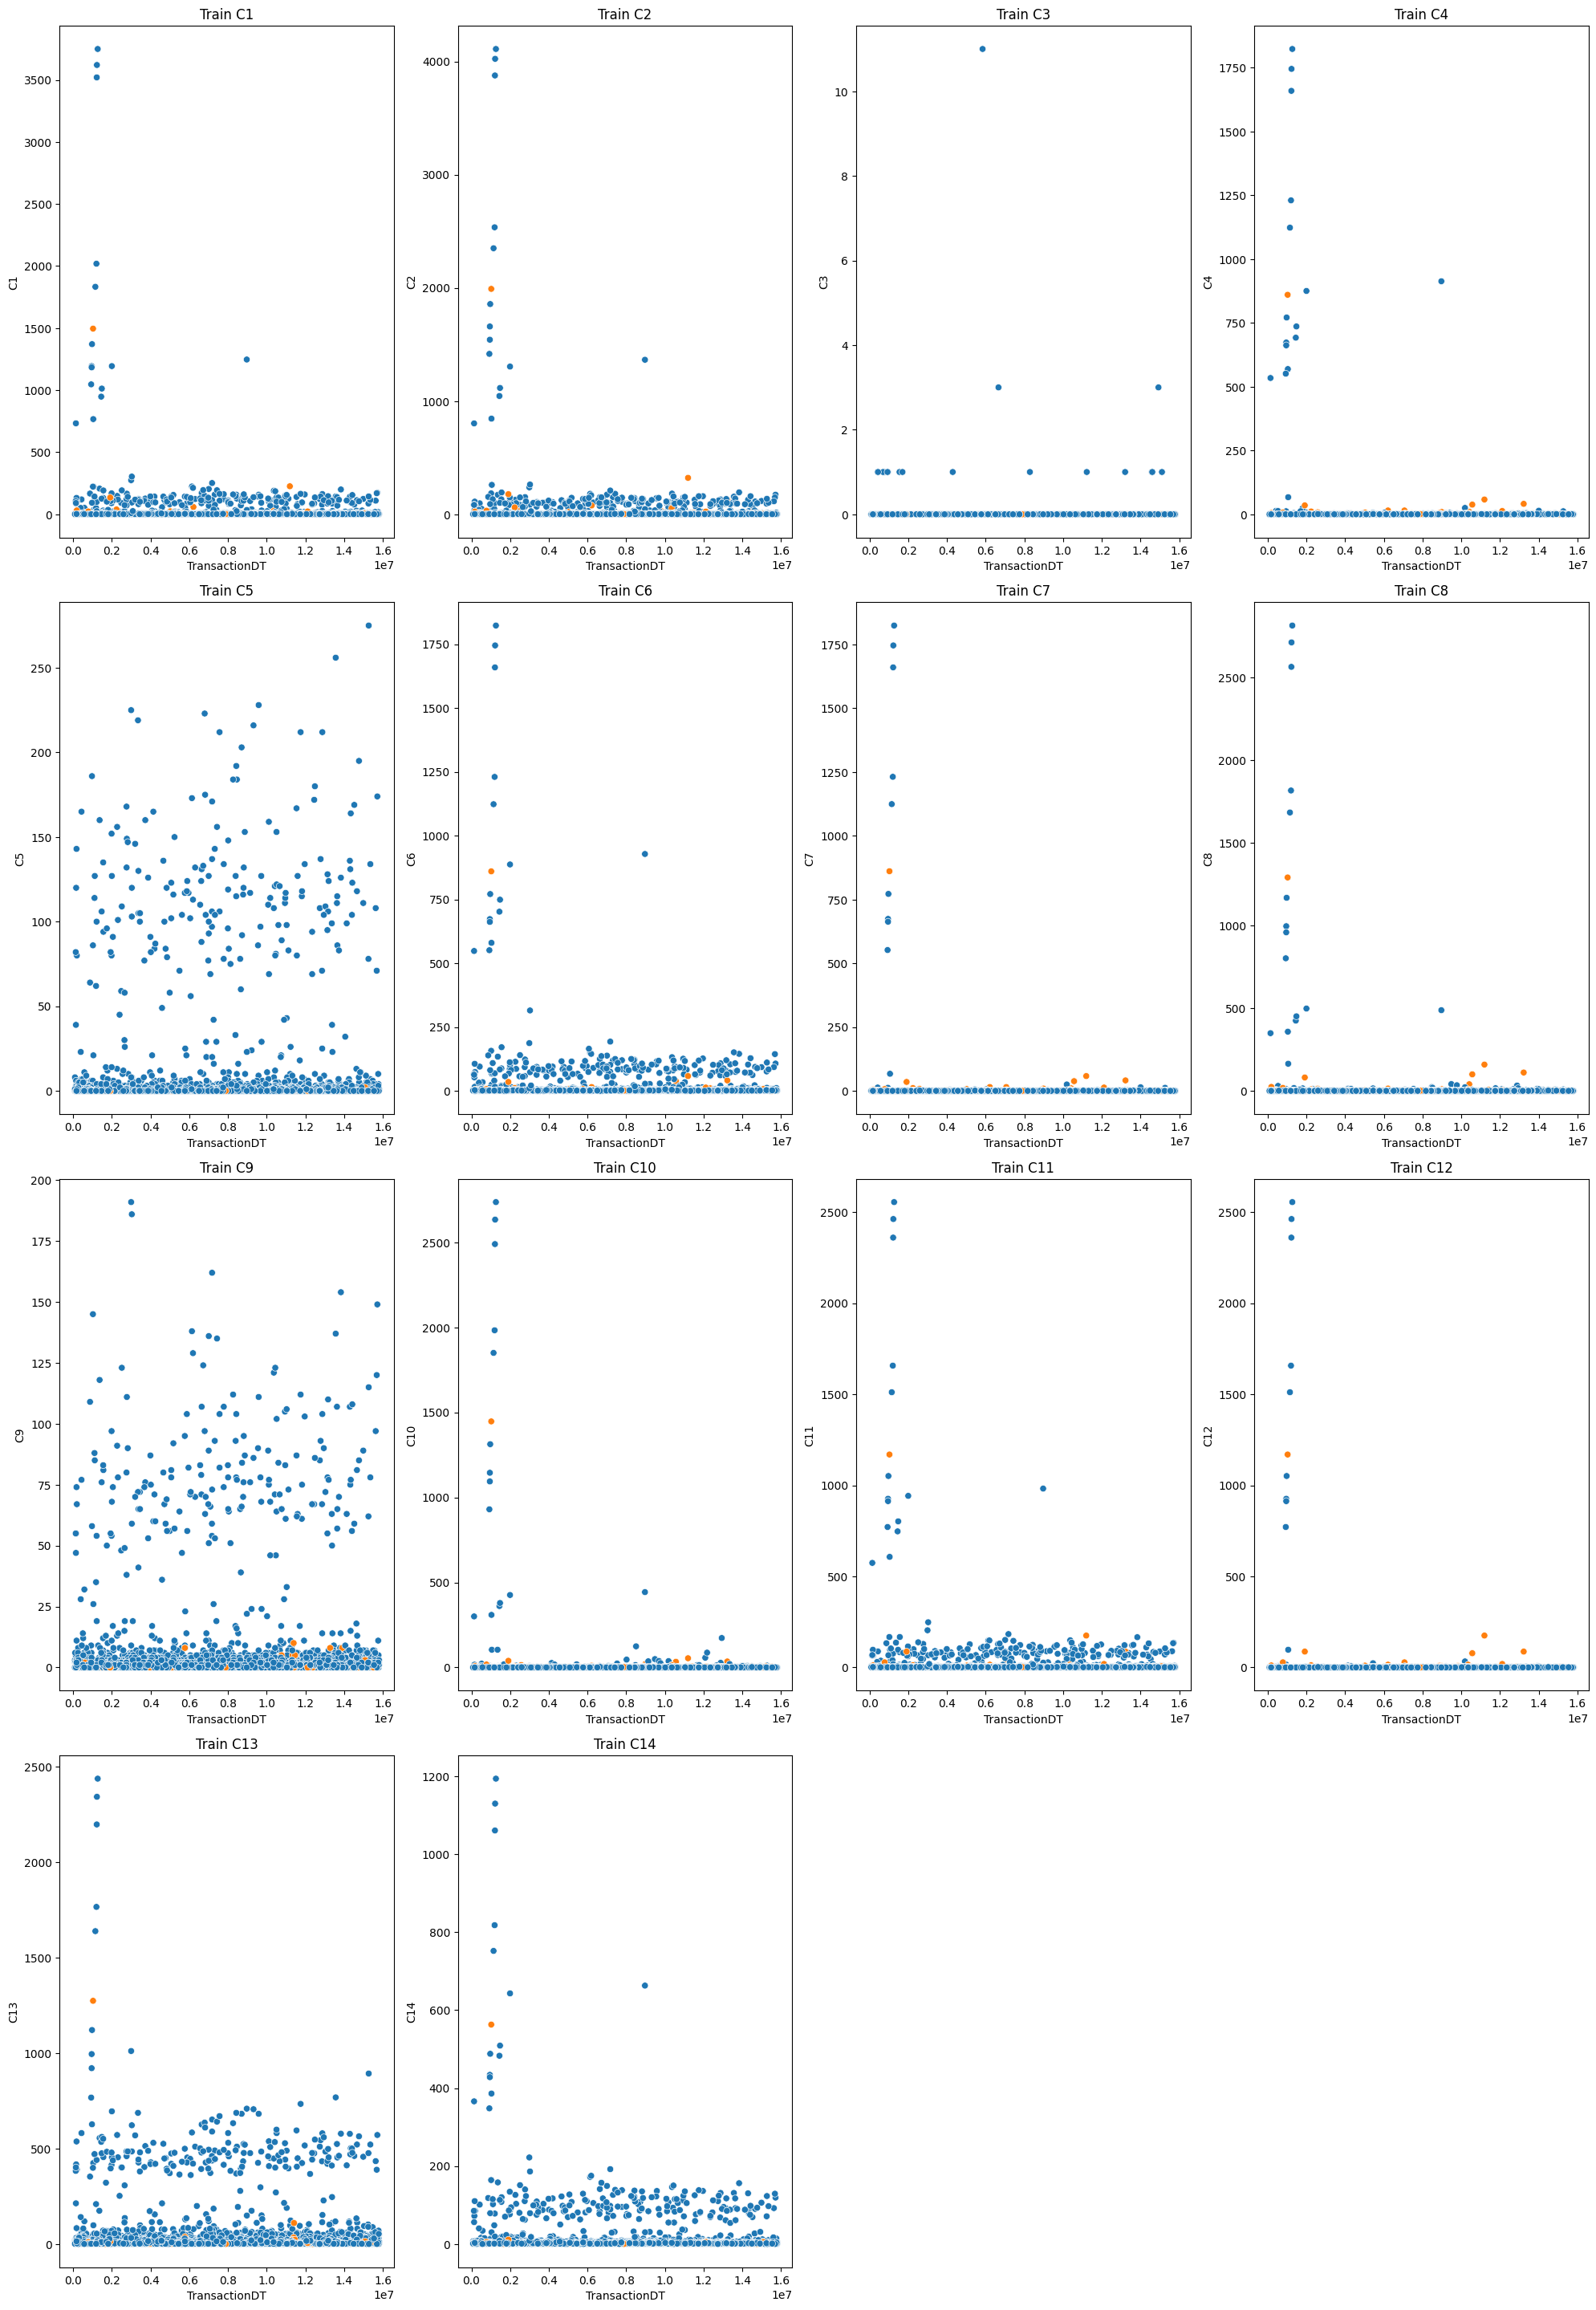

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Creating legend with loc=\"best\" can be slow with large amounts of data")
train_sample = train.sample(n=5000)
plt.figure(figsize=(20, 50))
var = ['C' + str(i) for i in range(1, 15)]
i = 1
for col in var:
    plt.subplot(7, 4, i)
    sns.scatterplot(x="TransactionDT", y=col, hue="isFraud", data=train_sample[~train_sample[col].isnull()], legend=False)
    plt.title(f'Train {col}')
    i += 1
plt.tight_layout()
plt.show()

On remarque que C5 et C9 n'ont pas de données aberrantes, contrairement aux autres.

Toutes les colonnes C sont de type numérique, et le résumé est présenté ci-dessous.

In [ ]:
print(train[var].isnull().sum().sum())


0


### **D1-D15**  imedelta, comme les jour entre la transactions  etc.

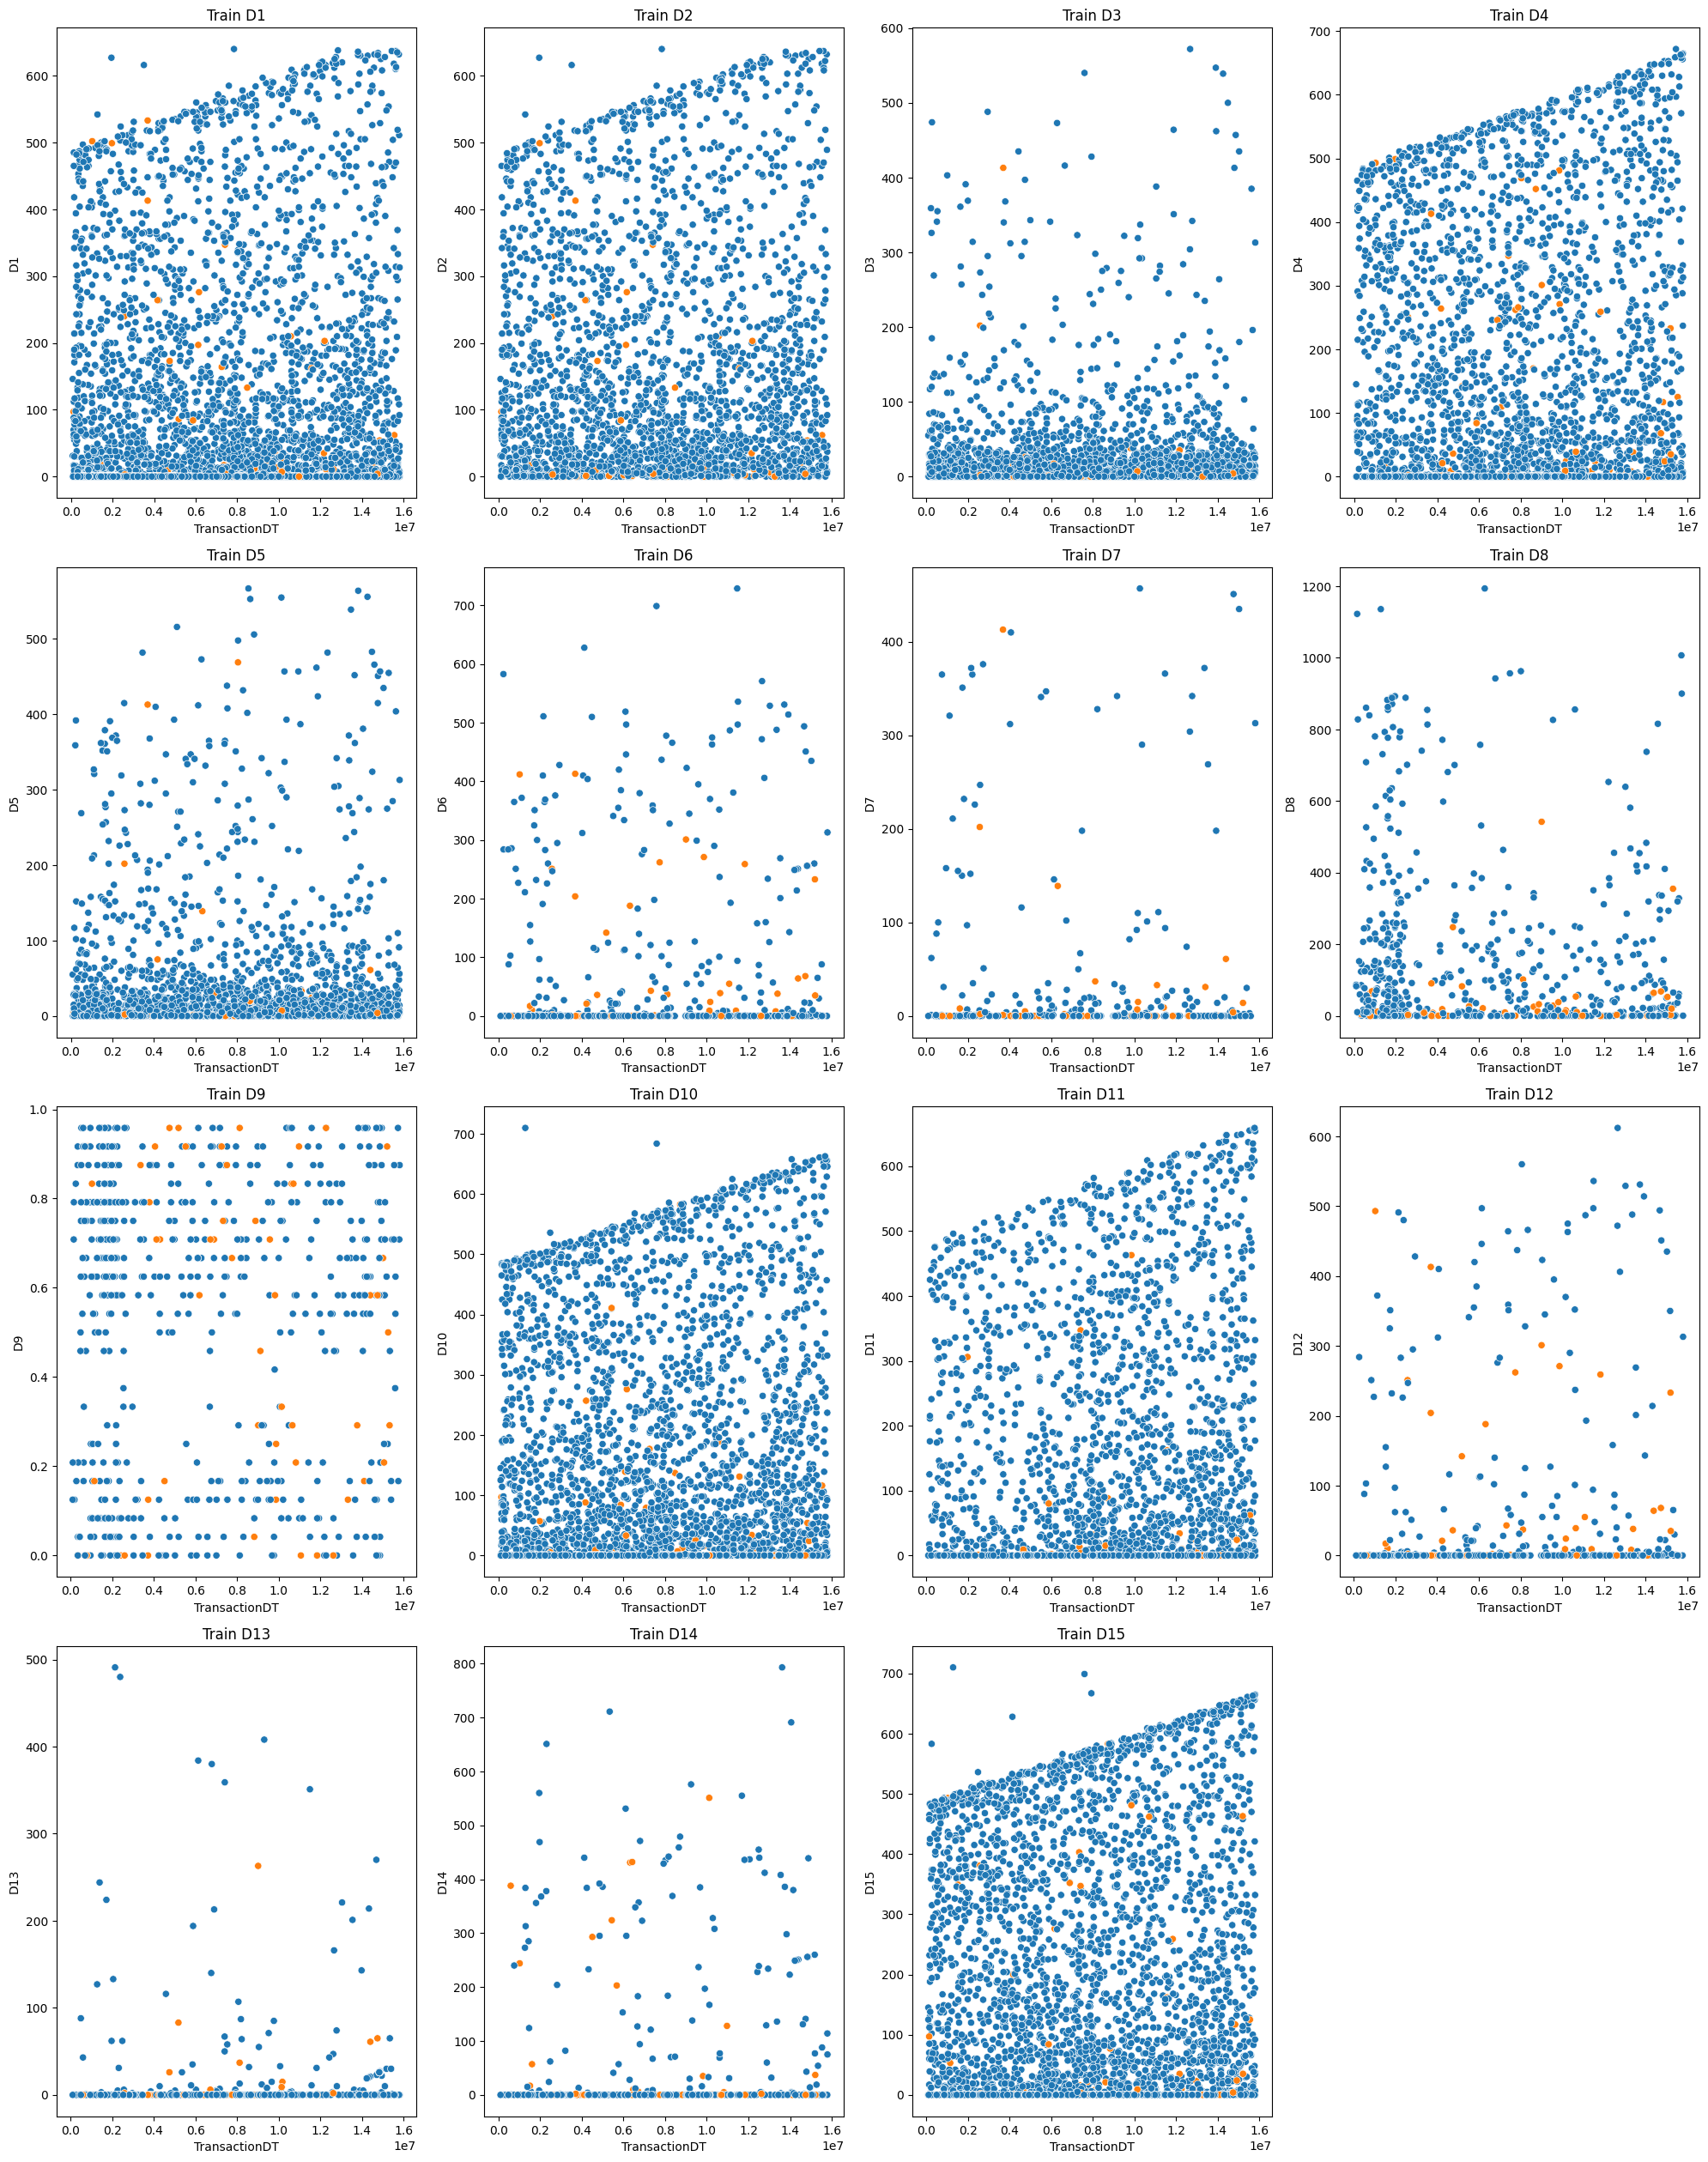

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, message="Creating legend with loc=\"best\" can be slow with large amounts of data")
train_sample = train.sample(n=5000)
plt.figure(figsize=(20, 50))
var = ['D' + str(i) for i in range(1, 16)]
i = 1
for col in var:
    plt.subplot(8, 4, i)
    sns.scatterplot(x="TransactionDT", y=col, hue="isFraud", data=train_sample[~train_sample[col].isnull()], legend=False)
    plt.title(f'Train {col}')
    i += 1
plt.tight_layout()
plt.show()

La plupart des fonctionnalités D augmentent de manière monotone avec TransactionDT, ce qui est logique car elles sont présentées par Vesta comme timedelta, telles que les jours entre la transaction précédente, etc.

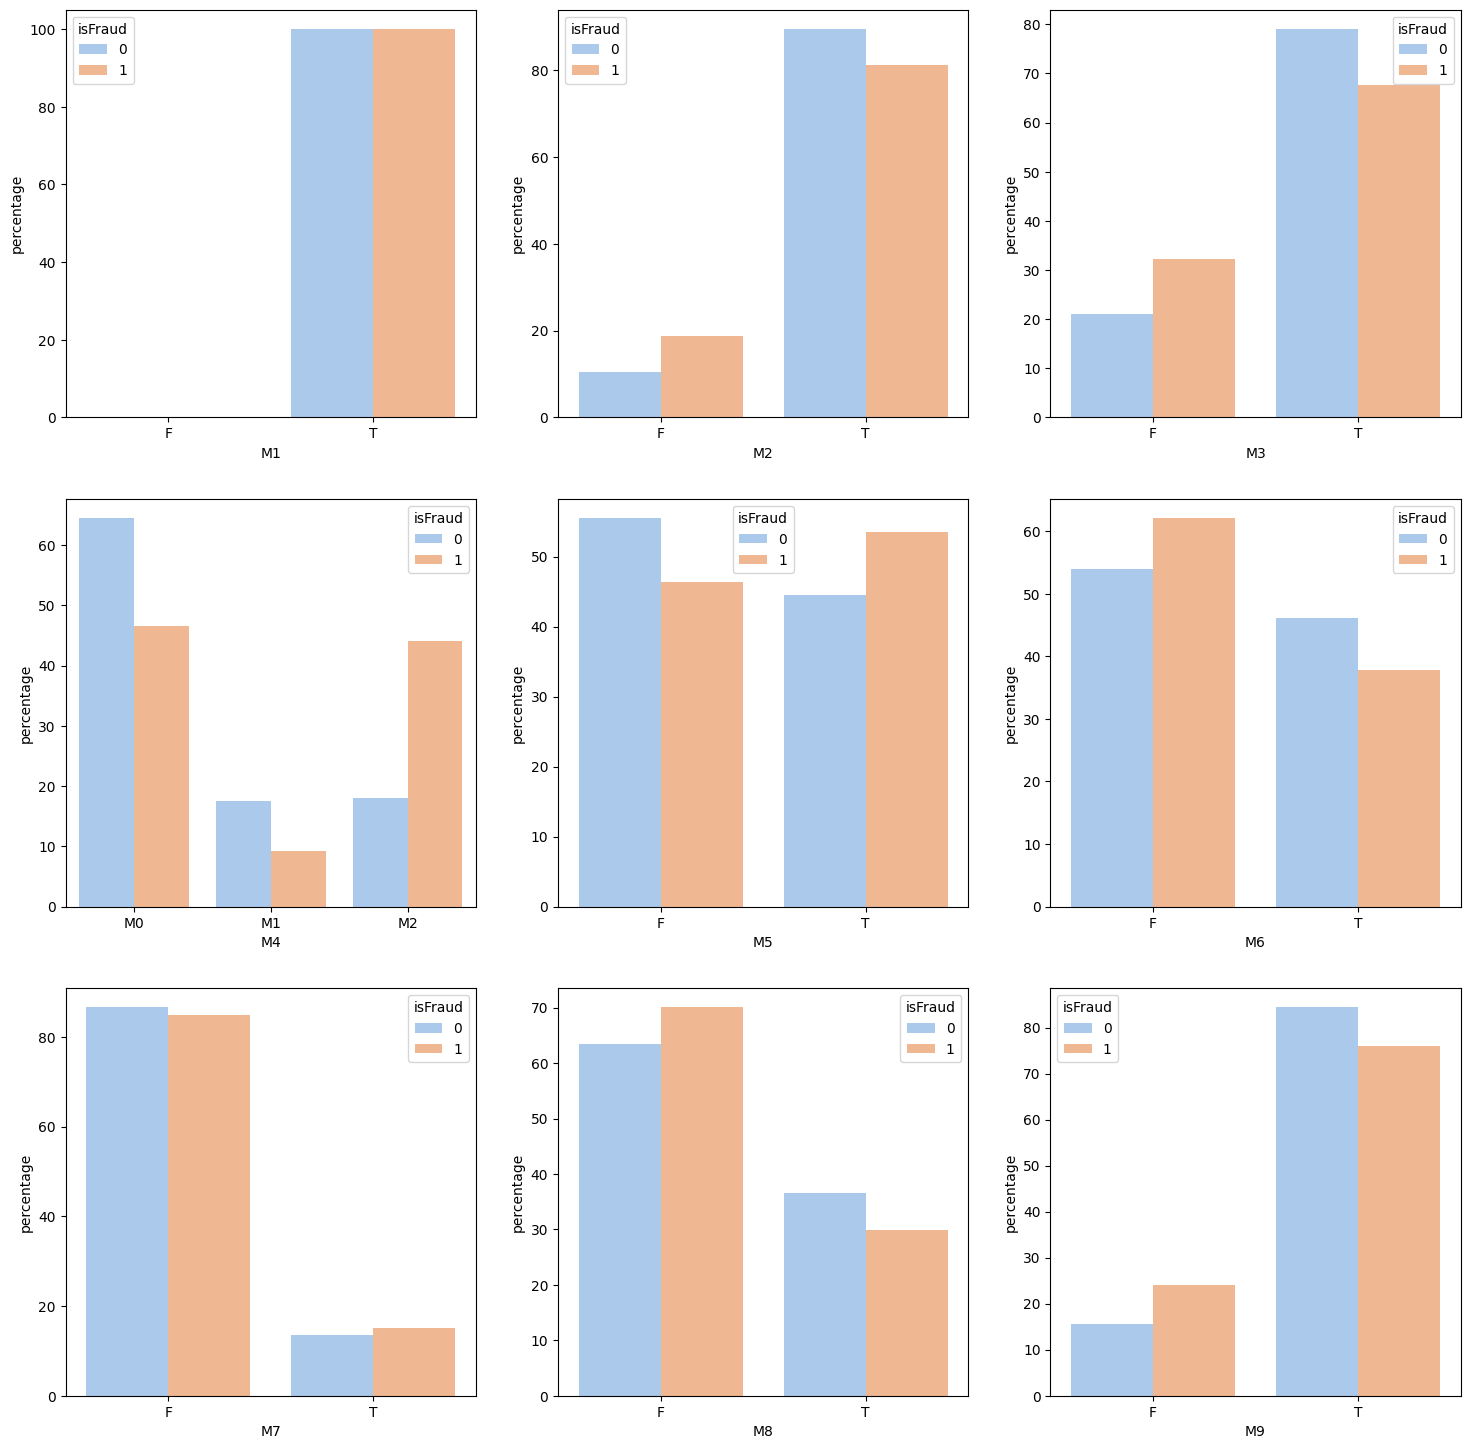

In [ ]:
plt.figure(figsize=(18,18))
var = ['train_m' + str(i) for i in range(1,10)]
col = ['M' + str(i) for i in range(1,10)]
for i,j,k in zip(var,col,range(1,10)):
    i = (train.groupby(['isFraud'])[j]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values(j))
    plt.subplot(3,3,k)
    sns.barplot(x=j, y="percentage", hue="isFraud", data=i, palette = 'pastel')
plt.show()

Pour chaque colonne, on remarque que le taux d'observations frauduleuses est le même que celui des observations non frauduleuses pour les deux valeurs (T, F, ...etc).

### **V features**:
Vesta a conçu des fonctionnalités riches, notamment le classement, le comptage et d'autres relations entre entités.

**Extraction et affichage des colonnes commençant par 'V'**

In [ ]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  V332  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   

   V333  V334  V335  V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

Beaucoup de 1,0 et NAN, mais seulement quelques valeurs plus grandes

In [ ]:
train[v_cols].describe()

V1             V2             V3             V4  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.999945       1.045204       1.078075       0.846456   
std         0.007390       0.240133       0.320890       0.440053   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.876991       1.045686       1.072870       1.027704   
std         0.475902       0.239385       0.304779       0.186069   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10  ...          V330           V331  \
count  311253.000000  311253.000000  ...  82351.000000   82351.000000   
mean        1.041529       0.463915  ...      0.775874     721.741883   
std         0.226339       0.521522  ...      4.727971    6217.223583   
min         0.000000       0.000000  ...      0.000000       0.000000   
25%         1.000000       0.000000  ...      0.000000       0.000000   
50%         1.000000       0.000000  ...      0.000000       0.000000   
75%         1.000000       1.000000  ...      0.000000       0.000000   
max         8.000000       4.000000  ...     55.000000  160000.000000   

                V332           V333          V334         V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.00000  82351.000000   
mean     1375.783644    1014.622782      9.807015     59.16455     28.530903   
std     11169.275702    7955.735482    243.861391    387.62948    274.576920   
min         0.000000       0.000000      0.000000      0.00000      0.000000   
25%         0.000000       0.000000      0.000000      0.00000      0.000000   
50%         0.000000       0.000000      0.000000      0.00000      0.000000   
75%        25.000000       0.000000      0.000000      0.00000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.00000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352422     151.160542     100.700882  
std       668.486833    1095.034387     814.946722  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 339 columns]

On prend les moyenne de chaque V feature pour dessiner le graphe

In [ ]:
train['v_mean'] = train[v_cols].mean(axis=1)

Une transformation logarithmique pour mieux montrer

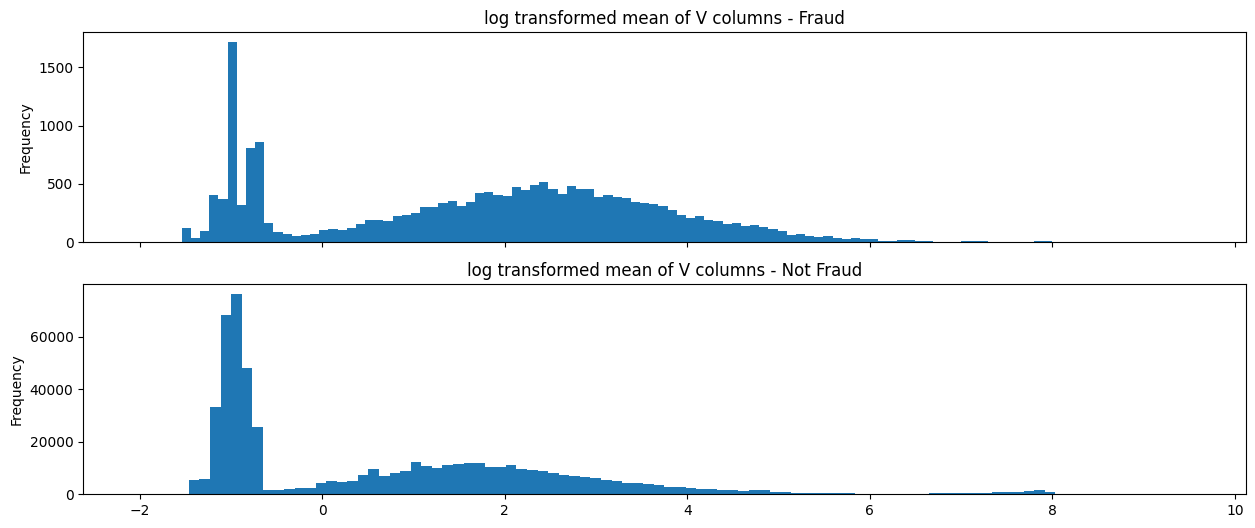

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train.loc[train['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train.loc[train['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          ax=ax2)
plt.show()

Il est difficile de tirer des informations, car il n'y a pas vraiment de différences entre les transactions frauduleuses et non frauduleuses concernant Vxx.

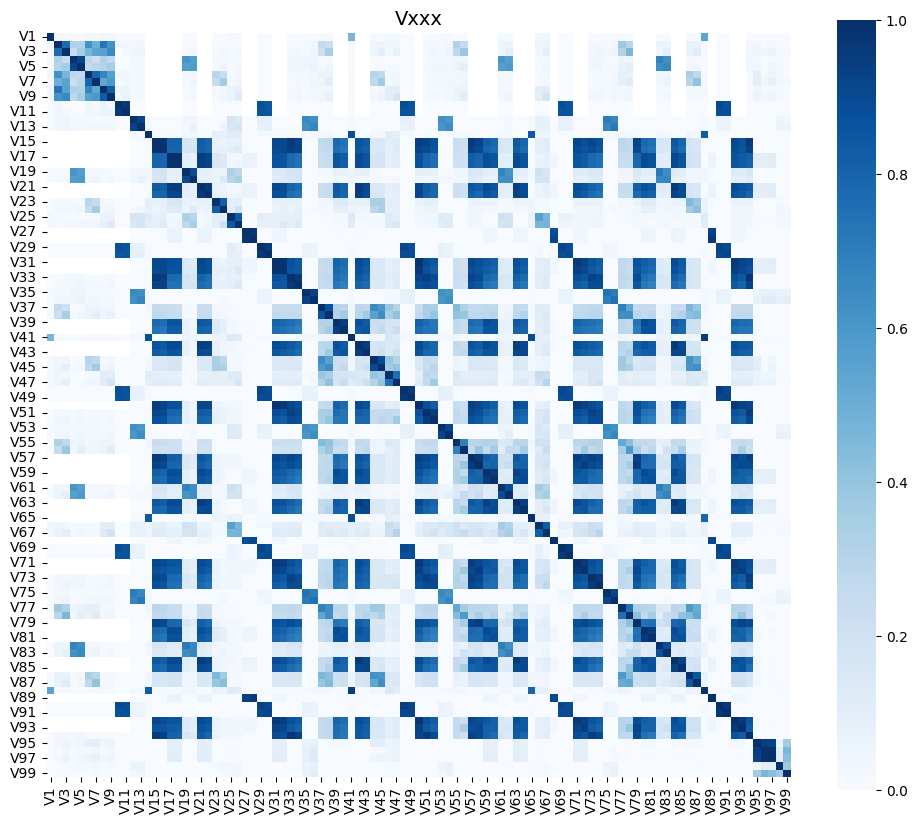

In [ ]:
v_cols = ['V{}'.format(i) for i in range(1, 100, 1)]
corr_table = train[v_cols].corr()
fig = plt.figure(figsize=(12, 10), facecolor='w')
sns.heatmap(corr_table, vmin=0, vmax=1, center=0.5, square=True, cmap='Blues')
plt.title('Vxxx', fontsize=14)
plt.show()

On remarque que la plupart des colonnes V semblent redondantes et corrélées. C'est pourquoi nous avons l'idée d'effectuer une PCA sur les fonctionnalités V, ce qui peut non seulement réduire la dimensionnalité, mais aussi économiser du temps d'exécution et décorréler les fonctionnalités pour améliorer les performances du modèle.

L'inconvénient de la PCA est que nous perdrons l'interprétation des fonctionnalités, mais ce n'est pas un problème majeur, car la signification de ces fonctionnalités V est de toute façon inconnue.

Les colonnes V contiennent 340 fonctionnalités, et la plupart semblent redondantes et corrélées. Il était difficile d'analyser toutes ces colonnes, et nous avons également des contraintes de temps. Nous pouvons donc simplement appliquer la PCA sur toutes les colonnes V dans la section suivante.

### **ID**

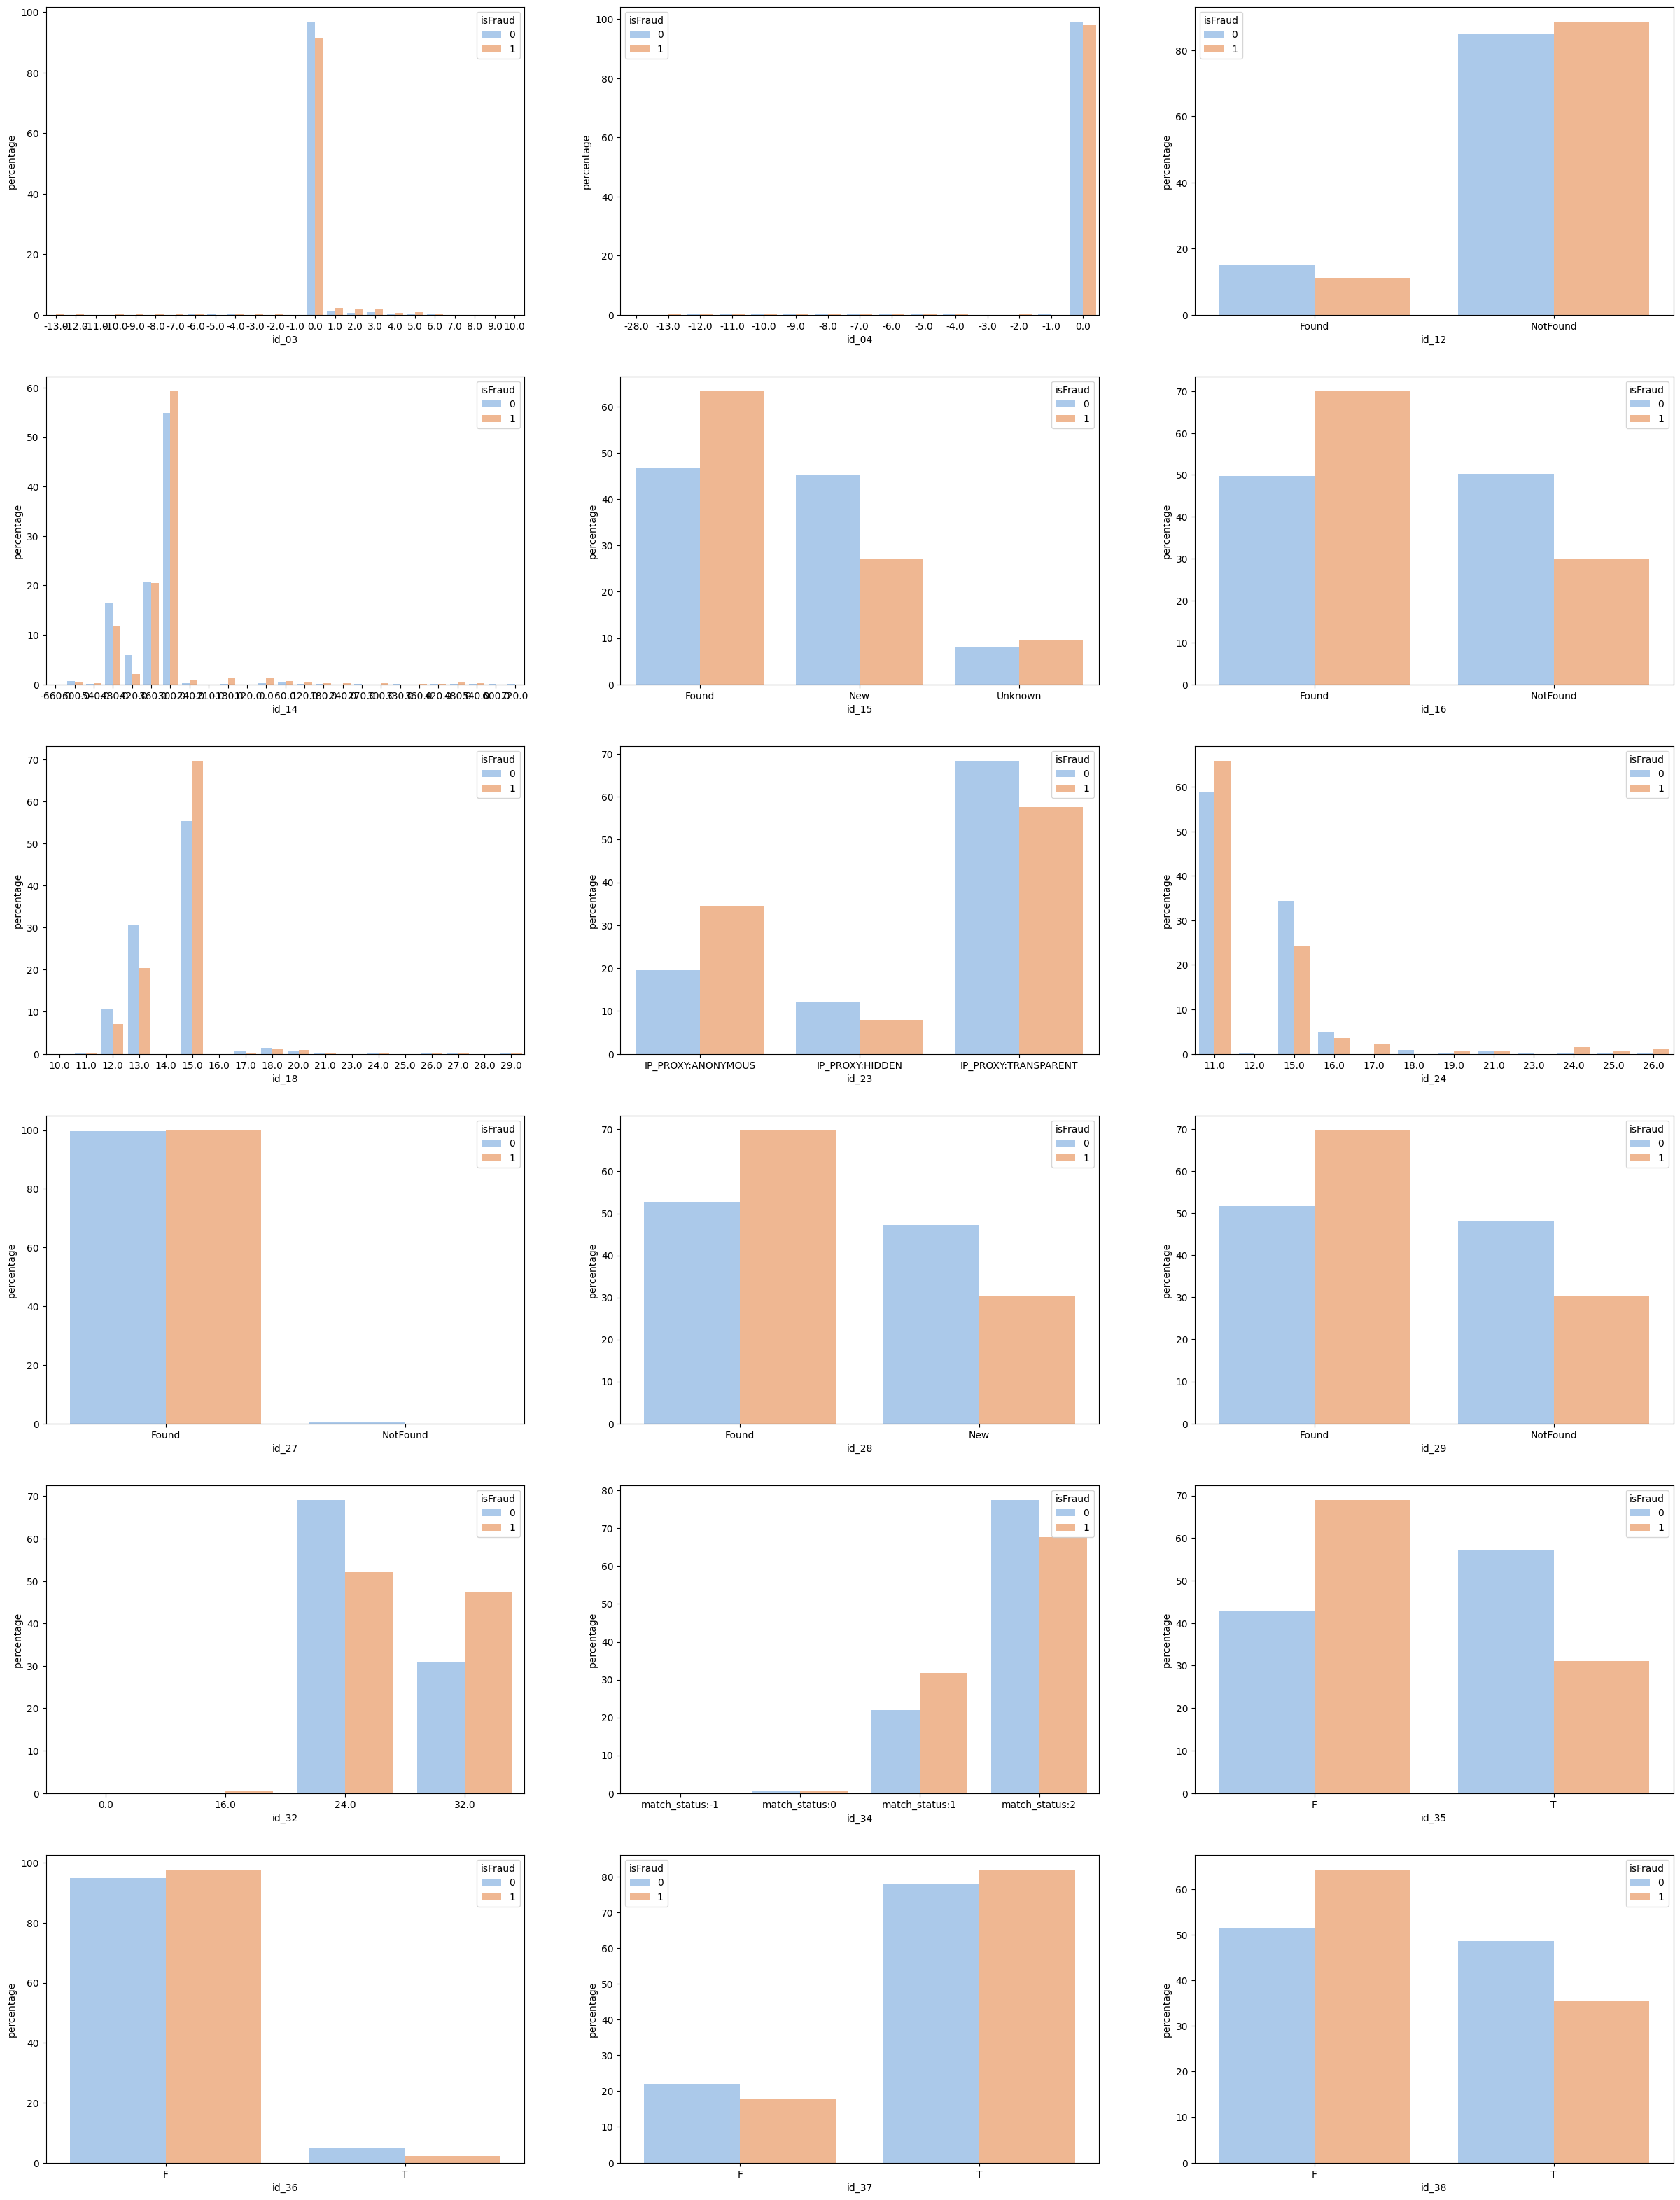

In [ ]:
plt.figure(figsize=(30,40))
var = ['train_id_' + str(i) for i in range(1,19)]
col = ['id_'+str(i) for i in ['03','04',12,14,15,16,18,23,24,27,28,29,32,34,35,36,37,38]]
for i,j,k in zip(var,col,range(1,19)):
    i = (train.groupby(['isFraud'])[j]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values(j))
    plt.subplot(6,3,k)
    sns.barplot(x=j, y="percentage", hue="isFraud", data=i, palette = 'pastel')
plt.show()

### **DeviceType and DeviceInfo**

In [ ]:
train[~train.iloc[:, 431:433].isnull().any(axis=1)].iloc[:, 431:433].head()

id_38 DeviceType
4      T     mobile
8      T     mobile
10     T    desktop
11     T    desktop
16     T    desktop

In [ ]:
print(len(train['DeviceType'].value_counts()))
print(len(train['DeviceInfo'].value_counts()))

2
1786


Le nombre de valeur dans la colonne DeviceType est 2 dans le train.

In [ ]:
train.drop(columns={"TransactionDT"},inplace=True)


###**Données manquantes**
Mon analyse trouve que :
- Parmi des centaines de variables, les suivantes sont enregistrées sans aucune
valeur manquante : TransactionID, TransactionDT, TransactionAmt, productCD, card
1 et toutes les variables C.
- En général, la proportion de valeurs manquantes est équivalente sur le train et le
test. Cependant, ce n’est pas toujours vrai pour certaines variables C et D

## **Prétraitement des données**
Dans cette section, je cite tous les prétraitements de données que j'ai effectué sur les données et que j'ai déduits en se basant sur la partie analyse faite précédemment.

1. Supprimer des caractéristiques

J'ai supprimé certaines colonnes de l’ensemble de données celles qui n'apportent
pas suffisamment d’information, comme les colonnes ayant plus de 80 % de valeurs (cases)
manquantes. J'ai également supprimé les colonnes ayant plus de 99% de leurs
valeurs identiques c’est-à-dire presque toutes les observations ont la même valeur donc on
ne peut rien apprendre de ce type de caractéristique.

2. Regrouper les valeurs d’une colonne P_emaildomain et R_emaildomain

J'ai regroupé les valeurs des colonnes « P_emaildomaine » et « R_emaildomaine »
par les entreprises. Par exemple, les observations «yahoo.com» et «yahoo.com.mx» sont regroupées sous «Yahoo», les observations « hotmail.com » et « outlook.com » sont
regroupées sous « microsoft ».

Toutes les valeurs avec moins de 500 entrées sont définies
comme « Autres» et toutes les valeurs manquantes sont remplies par «NoInf».
Card3
Comme j'ai vu dans la partie analyse, les valeurs de “card3” autour de 150 ont plus
de chances d'être légitimes(non frauduleuses); et les valeurs autour de 180 sont plus
susceptibles de l'être, ce qui nous permet de regrouper les valeurs de la colonne ‘’card3’’ de
la manière suivante :

- Si la valeur est supérieure à 160, alors «Positive».
- Sinon 'Négatif'

3. Remplacer les valeurs des variables
**card6**

D'après l’analyse On remarque dans “card6”, seules 15 observations sont des «charge
card» et 30 observations sont des «debit or credit» dans l'ensemble de train. Comme la taille de l'échantillon n'est pas suffisante pour trouver un
schéma général et que le type de “card6” majoritaire est «debit», donc j'ai
remplacé les valeurs minoritaires par «debit».

**TransactionDT**

J'ai remplacé la colonne transactionDT par une colonne « Heure » qui donne le
temps en heure même si l’heure ne représente pas l’heure exacte de la journée mais les
heures par rapport au début de la sauvegarde des données et cette nouvelle colonne
apporte plus d’information que l’ancienne colonne qui a des valeurs continues toutes
différentes.

### **Identic Columns**

In [ ]:
# Fonction pour calculer le taux IV (Information Value) pour chaque colonne
def get_rate_IV(df_train_complete):
    nbr = df_train_complete.shape[0]
    df_col_elim = []

    for i in range(df_train_complete.shape[1]):

        max_rate_IV = (df_train_complete.iloc[:, i].value_counts().max()) / nbr
        df_col_elim.append({"Column": df_train_complete.columns[i], "Rate_M_IV": max_rate_IV})

    return pd.DataFrame(df_col_elim)

# Fonction pour éliminer les colonnes ayant un taux IV supérieur à un seuil donné
def eliminate_rate_IV(df_train_complete):
    df_col_elim = get_rate_IV(df_train_complete)

    cols_to_drop = df_col_elim[df_col_elim["Rate_M_IV"] > 0.99]["Column"]

    print(f"Colonnes à éliminer : {cols_to_drop.tolist()}")

    df_train_complete.drop(columns=cols_to_drop, axis=1, inplace=True)
eliminate_rate_IV(train)


Colonnes à éliminer : ['C3', 'V107', 'V108', 'V110', 'V111', 'V112', 'V113', 'V114', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V305']


### **Traiter les valeurs manquantes(Missing Values)**
J'ai tenté d’utiliser les techniques récentes et plus performantes quand le taux des
valeurs manquantes est élevé, comme l’imputation multiple implémenté dans la bibliothèque
SKlearn mais comme l’ensemble des données est très grand et ma machine n’a pas
suffisamment de ressources (RAM) j'ai pas pu l’utiliser. J'ai imputé les
valeurs manquantes des colonnes catégorielles par le mode de chacune des colonnes. Et
les valeurs manquantes des colonnes numériques par la médiane car on a des
données aberrantes.

In [ ]:
def detectmissing(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']] #we ignore the column "index"
    summary['Missing(%)'] = (df.isnull().sum().values / df.shape[0])*100
    #summary['Uniques'] = df.nunique().values
    return summary

In [ ]:
summary_train=detectmissing(train)

 **Delete the columns with rate of missing values >=80**

In [ ]:
def delete_col_80(df_train_complete,summary_train):
  col_80= summary_train[summary_train["Missing(%)"]>= 80]["Name"].tolist()
  df_train_complete.drop(col_80, axis=1, inplace=True)

delete_col_80(train,summary_train)

 **Impute Missing values**

In [ ]:
def imputeDM(train):
    if 'isFraud' not in train.columns:
        raise KeyError("'isFraud' n'est pas présent dans les colonnes du DataFrame train.")

    Y = train['isFraud']
    train = train.drop(columns=['isFraud'])

    # Imputation pour les colonnes catégoriques
    cat_cols = train.select_dtypes(include='object').columns
    for col in cat_cols:
        if col in train.columns:
            train[col] = train[col].fillna(train[col].mode()[0])

    # Imputation pour les colonnes numériques
    num_cols = train.select_dtypes(include=np.number).columns
    for col in num_cols:
        if col in train.columns:
            train[col] = train[col].fillna(train[col].median())

    train['isFraud'] = Y
    return train
train = imputeDM (train)


<ipython-input-56-88f9c01a1318>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['isFraud'] = Y


### **Traiter les données aberrantes(Outliers)**
J'ai remarqué lors de l’analyse exploratoire des colonnes qui ont des valeurs qui
s’écartent de la majorité des valeurs de la colonne. J'ai décidé de les sélectionner et
de les remplacer par la moyenne des colonnes pour ne pas biaiser les estimations des
paramètres lors de la construction du modèle de la classification.

In [ ]:
train.columns.unique()

Index(['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'hour',
       'LogTransactionAmt', 'v_mean', 'isFraud'],
      dtype='object', length=347)

In [ ]:
train['isFraud'].value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64>

In [ ]:
print(train[train["isFraud"]==1 ].shape)

(20663, 347)


In [ ]:
train.drop(train[train.dist1>6000].index, axis=0, inplace=True)
train.drop(train[train.TransactionAmt>10000].index, axis=0, inplace=True)
train.loc[train.C1 > 3000, "C1" ] = train.loc[train.C1 <= 3000, "C1" ].mean()
train.loc[train.C2 > 3000, "C2" ] = train.loc[train.C2 <= 3000, "C2" ].mean()
train.loc[train.C4 > 1400, "C4" ] = train.loc[train.C4 <= 1400, "C4" ].mean()
train.loc[train.C6 > 1600, "C6" ] = train.loc[train.C6 <= 1600, "C6" ].mean()
train.loc[train.C7 > 1400, "C7" ] = train.loc[train.C7 <= 1400, "C7" ].mean()
train.loc[train.C8 > 1000, "C8" ] = train.loc[train.C8 <= 1000, "C8" ].mean()
train.loc[train.C10 > 2000, "C10" ] = train.loc[train.C10 <= 2000, "C10" ].mean()
train.loc[train.C11 > 2000, "C11" ] = train.loc[train.C11 <= 2000, "C11" ].mean()
train.loc[train.C12 > 2000, "C12" ] = train.loc[train.C12 <= 2000, "C12" ].mean()
train.loc[train.C13 > 1200, "C13" ] = train.loc[train.C13 <= 1200, "C13" ].mean()
train.loc[train.C14 > 800, "C14" ] = train.loc[train.C14 <= 800, "C14" ].mean()

In [ ]:
print(train[train["isFraud"]==1 ].shape)

(20663, 347)


### **Transformer les valeurs catégorielles(labelEncoder)**

Les données catégorielles sont les données qui n'ont besoin que d'un nombre limité de
valeurs possibles. Les algorithmes d'apprentissage automatique ne peuvent pas fonctionner
directement avec des données catégorielles et pour les utiliser, les catégories doivent
d'abord être transformées en numérique avant de pouvoir leur appliquer l'algorithme
d'apprentissage.

Il existe plusieurs techniques à appliquer, notamment One hot encoding qui est une solution
pour les catégories car elle nous permet de garder au maximum l’information sur les
données, Cependant s’il y a plusieurs valeurs uniques dans la même colonne, la taille de
l’ensemble de données sera considérablement augmentée.

Pour cela, j'ai utilisé
l’encodage de labels (Label Encoder), certes ce genre d'encodage est utilisé pour les
données ordinals mais c'est une opération très pratique pour les données nominales lorsqu'il
y a beaucoup de valeurs différentes, c’est un principe simple dans lequel nous convertissons
la variable catégorielle en variable quantitative discrète.





In [ ]:
def LabelEncode(train):
  encoders = dict() ##La fonction dict () crée un dictionnaire.
  cat_cols = train.select_dtypes(include = 'object').columns
  for col_name in cat_cols :
    series_train = train[col_name]
    label_encoder = LabelEncoder()
    label_encoder.fit(list(series_train.astype(str).values))

    train[col_name] = pd.Series(
    label_encoder.transform(series_train),
    index=series_train.index
    )

  return (train)

train=LabelEncode(train)

### **Mise à l'échelle des fonctionnalités(Normalisation)**
Après avoir géré les valeurs aberrantes nous utilisons la normalisation, Cette méthode
consiste à remettre les valeurs dans une plage de [0,1] ou parfois de [-1, 1]. Elle se calcule :
Xnormalized = X−Xmin /Xmax−Xmin.
On a envisagé cette méthode afin de laisser les variables binaires, telles qu’elles sont sans
changer leurs sens, et Vu que nous aurons besoin de la variable «TransactionID » pour la
soumission du fichier à kaggle, par conséquent j'ai fait une normalisation sans
toucher à cette dernière.

In [ ]:
def normalize(train):
    cols = train.columns.tolist()
    cols.remove("TransactionID")

    for col in cols:
        train[col] = minmax_scale(train[col])

    return train

train = normalize(train)

### **Réduire la mémoire**
J'ai constaté que les données ont occupé plus de 1,9 Go de RAM. De plus j'ai remarqué la présence de différents types de variables notamment Float64 et int 64.
Par conséquent j'ai changé ces dernières en float32 et en int32 respectivement.
Pour cela, l'utilisation de la mémoire est réduite de près de 50%.

In [ ]:
import pandas as pd
import numpy as np

# Fonction pour calculer la mémoire utilisée par un DataFrame
def memory_usage_mb(df, *args, **kwargs):
    """Retourne l'utilisation mémoire d'un DataFrame en MB."""
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

# Fonction pour réduire la mémoire utilisée par un DataFrame
def reduce_memory_usage(df, deep=True, verbose=True):
    """
    Réduit l'utilisation de la mémoire des colonnes numériques d'un DataFrame.
    - Convertit les colonnes int64 en int8/int16/int32.
    - Convertit les colonnes float64 en float32.

    Parameters:
        df (pd.DataFrame): Le DataFrame à optimiser.
        deep (bool): Si True, calcule la mémoire avec précision.
        verbose (bool): Si True, affiche les réductions effectuées.

    Returns:
        pd.DataFrame: Le DataFrame optimisé.
    """
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)
        print(f"Initial memory usage: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtypes
        best_type = None

        if str(col_type) in numeric2reduce:
            try:

                downcast = "integer" if "int" in str(col_type) else "float"
                df[col] = pd.to_numeric(df[col], downcast=downcast)
                best_type = df[col].dtype.name
            except Exception as e:
                print(f"Skipping column '{col}' due to error: {e}")


        if verbose and best_type is not None and best_type != str(col_type):
            print(f" Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB "
              f"({diff_mem:.2f} MB, {percent_mem:.2f}% reduction)")

    return df

train = reduce_memory_usage(train, verbose=True)


Initial memory usage: 1567.87 MB
 Column 'TransactionID' converted from int64 to int32
 Column 'TransactionAmt' converted from float64 to float32
 Column 'ProductCD' converted from float64 to float32
 Column 'card1' converted from float64 to float32
 Column 'card2' converted from float64 to float32
 Column 'card3' converted from float64 to float32
 Column 'card4' converted from float64 to float32
 Column 'card5' converted from float64 to float32
 Column 'card6' converted from float64 to float32
 Column 'addr1' converted from float64 to float32
 Column 'addr2' converted from float64 to float32
 Column 'dist1' converted from float64 to float32
 Column 'P_emaildomain' converted from float64 to float32
 Column 'R_emaildomain' converted from float64 to float32
 Column 'C1' converted from float64 to float32
 Column 'C2' converted from float64 to float32
 Column 'C4' converted from float64 to float32
 Column 'C5' converted from float64 to float32
 Column 'C6' converted from float64 to float32

### **Réduire la dimensionnalité(ACP)**
J'ai effectué la PCA sur les colonnes V pour réduire la dimensionnalité et pour
économiser le code en termes de temps d’exécution. Le choix d’appliquer la PCA sur ces
colonnes est révélé de la phase d’analyse où j'ai constaté que la plupart de ces
fonctionnalités sont corrélées les unes aux autres.

J'ai pu passer de 280 colonnes à 100 composantes principales expliquant 100% de
l’information contenue dans les colonnes d’entrées (FIGURE-11 ), et ces composantes sont
décorrélées ce qui permet d’améliorer les performances du modèle.

L'inconvénient de la PCA est que nous perdrons l'interprétation des fonctionnalités. Mais ce
n'est pas un gros problème puisque la signification de ces fonctionnalités V est de toute
façon inconnue.

In [ ]:
train.reset_index()
Vxx = train.loc[:,"V1":"V321"]

In [ ]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    #pca = PCA(random_state=rand_seed)
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])


    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = df.merge(principalDf,right_index =True, left_index =True)

    return (df,pca)





**Ne pas exécuter cette section**
cette section sert à trouver la valeur du paramètre "n_components" de l'ACP

In [ ]:
# Imputer les valeurs manquantes par la moyenne
train[Vxx.columns] = train[Vxx.columns].fillna(train[Vxx.columns].mean())


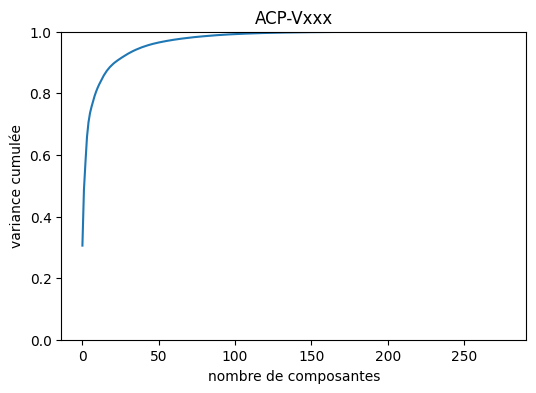

In [ ]:
train, pca = PCA_change(train, Vxx.columns, n_components=Vxx.shape[1], prefix='PCA_V_', rand_seed=4)
x = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.cumsum(x))
ax.set(xlabel="nombre de composantes", ylabel="variance cumulée", title="ACP-Vxxx", ylim=(0, 1))
plt.show()


**Exécuter ce code pour n_component = 100**

In [ ]:
print("Colonnes dans train :")
print(train.columns)

print("Colonnes spécifiées dans Vxx.columns :")
print(Vxx.columns)


Colonnes dans train :
Index(['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'PCA_V_268', 'PCA_V_269', 'PCA_V_270', 'PCA_V_271', 'PCA_V_272',
       'PCA_V_273', 'PCA_V_274', 'PCA_V_275', 'PCA_V_276', 'PCA_V_277'],
      dtype='object', length=347)
Colonnes spécifiées dans Vxx.columns :
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=278)


Colonnes valides à inclure dans PCA : ['PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5', 'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9', 'PCA_V_10', 'PCA_V_11', 'PCA_V_12', 'PCA_V_13', 'PCA_V_14', 'PCA_V_15', 'PCA_V_16', 'PCA_V_17', 'PCA_V_18', 'PCA_V_19', 'PCA_V_20', 'PCA_V_21', 'PCA_V_22', 'PCA_V_23', 'PCA_V_24', 'PCA_V_25', 'PCA_V_26', 'PCA_V_27', 'PCA_V_28', 'PCA_V_29', 'PCA_V_30', 'PCA_V_31', 'PCA_V_32', 'PCA_V_33', 'PCA_V_34', 'PCA_V_35', 'PCA_V_36', 'PCA_V_37', 'PCA_V_38', 'PCA_V_39', 'PCA_V_40', 'PCA_V_41', 'PCA_V_42', 'PCA_V_43', 'PCA_V_44', 'PCA_V_45', 'PCA_V_46', 'PCA_V_47', 'PCA_V_48', 'PCA_V_49', 'PCA_V_50', 'PCA_V_51', 'PCA_V_52', 'PCA_V_53', 'PCA_V_54', 'PCA_V_55', 'PCA_V_56', 'PCA_V_57', 'PCA_V_58', 'PCA_V_59', 'PCA_V_60', 'PCA_V_61', 'PCA_V_62', 'PCA_V_63', 'PCA_V_64', 'PCA_V_65', 'PCA_V_66', 'PCA_V_67', 'PCA_V_68', 'PCA_V_69', 'PCA_V_70', 'PCA_V_71', 'PCA_V_72', 'PCA_V_73', 'PCA_V_74', 'PCA_V_75', 'PCA_V_76', 'PCA_V_77', 'PCA_V_78', 'PCA_V_79', 'PCA_V_80', 'PCA_V_81'

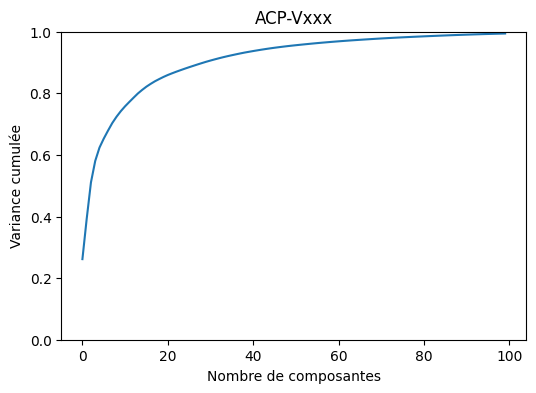

In [ ]:
Vxx.columns = ['PCA_V_' + col[1:] for col in Vxx.columns if col.startswith('V')]

valid_columns = [col for col in Vxx.columns if col in train.columns]

print(f"Colonnes valides à inclure dans PCA : {valid_columns}")

train, pca = PCA_change(train, valid_columns, n_components=100, prefix='PCA_V_', rand_seed=4)

x = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.cumsum(x))
ax.set(xlabel="Nombre de composantes", ylabel="Variance cumulée", title="ACP-Vxxx", ylim=(0, 1))
plt.show()


## **Modelisation**

####**Traiter les classes déséquilibrées**

Comme indiqué dans la distribution cible en analyse la plupart des transactions ne sont pas
des fraudes, donc dans ce cas, on a des données déséquilibrées. Les algorithmes
d'apprentissage automatique ne fonctionnent pas correctement avec un ensemble de
données déséquilibré, ce qui nous oblige à mettre en œuvre des techniques d'équilibrage.

Il existe plusieurs techniques d'équilibrage à la fois dans le sur-échantillonnage et le sous-
échantillonnage. En premier lieu j'ai utilisé l’argument class_weight=”balanced disponible dans les algorithmes de la bibliothèque SkLearn, mais comme cette approche
prend beaucoup de temps pour construire le modèle vu qu'on a beaucoup de
données .

J'ai opté pour la technique de sous-échantillonnage (Resample) qui est
une technique qui permet de supprimer des observations de la classe majoritaire de manière
aléatoire.

####**Fractionner les données**

La dernière chose que nous avons fait avant la modélisation est de diviser nos données en
un ensemble d'entraînement à 70% et un ensemble de test à 30%

####**Régler les hyper paramètres**

Il y a beaucoup d'hyper paramètres impliqués dans les algorithmes de classification utilisés.
Notre travail est donc comme un architecte pour trouver les meilleures valeurs afin de
maximiser la précision.

Il existe plusieurs techniques qui sont vraiment utiles, notamment GridSearchCV et RandomizedSearchCV. J'ai utilisé RandomisedSearchCV, vu que nous pouvons 14 choisir le nombre de combinaisons des hyper paramètres qu'elles génèrent, dans notre cas j'ai choisi 60 combinaisons.

####**La métrique utilisée**

Les courbes Roc & Auc sont des mesures de performance pour les problèmes de
classification binaire à différents réglages de seuils. Il nous montre à quel point le modèle est capable de distinguer les classes.

La métrique qu’on a utilisé ici est l’AUC (aire sous la
courbe ROC) , en effet l’AUC représente le degré ou la mesure de la séparabilité. Plus l'AUC est élevé, meilleur est le modèle pour prédire les 0 comme 0 et 1 comme 1.

##**Modèles d’apprentissage automatique**


### **Decision Tree**

**Decision Tree avec class_weight= balanced sans réglage d'hyperparamètres**

In [ ]:
Y = train["isFraud"]
X = train.drop(columns='isFraud')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)
base_tree.fit(X_train, Y_train)


base_tree_train_predict = base_tree.predict_proba(X_train)
base_tree_test_predict = base_tree.predict_proba(X_test)

print('base decision tree train auc:', roc_auc_score(Y_train, base_tree_train_predict[:,1]))

print('base decision tree train auc:', roc_auc_score(Y_test, base_tree_test_predict[:,1]))

base decision tree train auc: 1.0
base decision tree train auc: 0.7028362934955632


Le modèle Decision Tree obtient une AUC parfaite de 1.0 sur l'entraînement, mais chute à 0.703 sur le test, révélant un surapprentissage marqué et une capacité limitée de généralisation.

**Decision Tree avec class_weight= balanced avec réglage d'hyperparamètres**

In [ ]:
Y = train["isFraud"]
X = train.drop(columns='isFraud')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
# Function to measure the quality of a split
criterion = ['gini', 'entropy']
# Strategy used to choose the split at each node, random selects a set of features randomly and splits,
splitter = ['best', 'random']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# The number of features to consider when looking for the best split
max_features = ['auto', 'log2', None]
# Maximum number of leaf nodes
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
# Split threshold of a decrease of the impurity
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
# Complexity parameter used for Minimal Cost-Complexity Pruning
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
# Create the random grid
# Hyperparamètres élargis
random_grid = {
    'max_depth': [5, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tree_random = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=random_grid,
    n_iter=50,
    cv=skf,
    scoring='roc_auc',
    verbose=3,
    random_state=42,
    n_jobs=-1
)

In [ ]:
X_train_sample = X_train.sample(frac=0.3, random_state=42)
Y_train_sample = Y_train.loc[X_train_sample.index]

# Ajustement
tree_random.fit(X_train_sample, Y_train_sample)

# Prédictions
best_random_tree_train_predict = tree_random.predict_proba(X_train)
best_random_tree_test_predict = tree_random.predict_proba(X_test)

# Scores AUC
from sklearn.metrics import roc_auc_score
print('best random tree train auc:', roc_auc_score(Y_train, best_random_tree_train_predict[:, 1]))
print('best random tree test auc:', roc_auc_score(Y_test, best_random_tree_test_predict[:, 1]))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best random tree train auc: 0.8341131840213704
best random tree test auc: 0.8346056587239531


Le modèle Random Tree optimisé atteint une AUC de 0.834 sur l'entraînement et 0.835 sur le test, indiquant une performance équilibrée et une très bonne généralisation.

**Decision Tree avec Resample sans réglage d'hyperparamètres**

In [ ]:

# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)
# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])    # Concatenation
# let's check the classes counts
train.isFraud.value_counts()

isFraud
0.0    20662
1.0    20662
Name: count, dtype: int64

In [ ]:

Y = train["isFraud"]
X = train.drop(columns='isFraud')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)
base_tree.fit(X_train, Y_train)


base_tree_train_predict = base_tree.predict_proba(X_train)
base_tree_test_predict = base_tree.predict_proba(X_test)

print('base decision tree train auc:', roc_auc_score(Y_train, base_tree_train_predict[:,1]))

print('base decision tree train auc:', roc_auc_score(Y_test, base_tree_test_predict[:,1]))

base decision tree train auc: 1.0
base decision tree train auc: 0.7373911149457427


Le modèle Decision Tree affiche une AUC parfaite de 1.0 sur l'entraînement, mais chute à 0.737 sur le test, signalant un surapprentissage significatif et une généralisation limitée.

**Decision Tree avec Resample avec réglage d'hyperparamètres**

In [ ]:

# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)
# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])    # Concatenation
# let's check the classes counts
train.isFraud.value_counts()

isFraud
0.0    20662
1.0    20662
Name: count, dtype: int64

In [ ]:

Y = train["isFraud"]
X = train.drop(columns='isFraud')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45)

In [ ]:
# Function to measure the quality of a split
criterion = ['gini', 'entropy']
# Strategy used to choose the split at each node, random selects a set of features randomly and splits,
splitter = ['best', 'random']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# The number of features to consider when looking for the best split
max_features = ['auto', 'log2', None]
# Maximum number of leaf nodes
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
# Split threshold of a decrease of the impurity
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
# Complexity parameter used for Minimal Cost-Complexity Pruning
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
# Create the random grid
random_grid = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha}

# pprint(random_grid)

In [ ]:
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

tree_random = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=random_grid,
    n_iter=60,
    cv=skf,
    scoring='roc_auc',
    verbose=0,
    random_state=42,
    n_jobs=-1
)

tree_random.fit(X_train, Y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
51 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.005, 0.01, 0.015,
                                                      0.02, 0.025, 0.03, 0.035,
                                                      0.04, 0.045, 0.05],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 30, 50, 70, 90, 110,
                                                      130, 150, 170, 190, 210,
                                                      None],
                                        'max_features': ['auto', 'log2', None],
                                        'max_leaf_nodes': [10, 30, 50, 70, 90,
                                                           110, 130, 150, 170,
                                                           190, 210],
                                        'min_impurity_decrease': [0, 5e-05,
                                                                  0.0001,
                                                                  0.0002,
                                                                  0.0005, 0.001,
                                                                  0.0015, 0.002,
                                                                  0.005, 0.01,
                                                                  0.02],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 15, 30,
                                                              50, 100],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [ ]:
best_random_tree_train_predict = tree_random.predict_proba(X_train)
best_random_tree_test_predict = tree_random.predict_proba(X_test)
print('best random tree train auc:', roc_auc_score(Y_train, best_random_tree_train_predict[:,1]))
print('best random tree test auc:', roc_auc_score(Y_test, best_random_tree_test_predict[:,1]))

best random tree train auc: 0.8235021286836626
best random tree test auc: 0.8192788301834893


Le modèle Random Tree optimisé obtient une AUC de 0.824 sur l'entraînement et 0.819 sur le test, montrant une performance cohérente et une bonne capacité de généralisation.

### **Random Forest**

**RandomForest avec class_weight="balanced" et sans réglage d'hyperparamètres**

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45,stratify=Y)

In [ ]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
base_rf.fit(X_train, Y_train)
base_rf_train_predict = base_rf.predict_proba(X_train)
base_rf_test_predict = base_rf.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 1.0
base random forest test auc: 0.8928728988312333


Le modèle Random Forest affiche une AUC parfaite de 1.0 sur l'entraînement et 0.893 sur le test, suggérant une bonne performance globale, mais une forte indication de surapprentissage.

**RandomForest avec class_weight="balanced" et réglage des hyperparamétres**

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=45,stratify=Y)

In [ ]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)


In [ ]:
n_estimators = [10, 50]
criterion = ['gini']
min_samples_split = [10, 30]
min_samples_leaf = [20, 40]
max_features = [0.7, 'auto']

random_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features
}


In [ ]:
X_train_sample = X_train.sample(frac=0.1, random_state=42)
Y_train_sample = Y_train.loc[X_train_sample.index]


from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune: base_rf
# Random search of parameters with auc_roc scoring, using 3 fold stratified cross validation,
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_random = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=random_grid,
    n_iter=20,
    cv=skf,
    scoring='roc_auc',
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
rf_random.fit(X_train_sample, Y_train_sample)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini'],
                                        'max_features': [0.7, 'auto'],
                                        'min_samples_leaf': [20, 40],
                                        'min_samples_split': [10, 30],
                                        'n_estimators': [10, 50]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [ ]:
print(rf_random.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Configuration du RandomForestClassifier
rf_random = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight='balanced',
    criterion='gini',
    max_depth=80,
    max_features=0.7,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=20,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    n_estimators=30,
    n_jobs=-1,
    oob_score=False,
    random_state=42,
    verbose=0,
    warm_start=False
)

rf_random.fit(X_train, Y_train)


RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=0.7,
                       min_samples_leaf=20, min_samples_split=5,
                       n_estimators=30, n_jobs=-1, random_state=42)

In [ ]:
base_rf_train_predict = rf_random.predict_proba(X_train)
base_rf_test_predict = rf_random.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 0.9594886457882269
base random forest test auc: 0.8942500990368875


Le modèle Random Forest obtient une AUC de 0.959 sur l'entraînement et 0.894 sur le test, indiquant une performance solide avec un léger écart qui pourrait suggérer une légère tendance au surapprentissage.

**RandomForest avec Resample et sans réglage des hyperparamétres**

In [ ]:
from sklearn.utils import resample
# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False,
                                n_samples = len(fraud),
                                random_state = 27)

train = pd.concat([not_fraud_downsampled, fraud])
train.isFraud.value_counts()

isFraud
0.0    20662
1.0    20662
Name: count, dtype: int64

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
base_rf= RandomForestClassifier(random_state=42)

In [ ]:
base_rf.fit(X_train,Y_train)

RandomForestClassifier(random_state=42)

In [ ]:

base_rf_train_predict = base_rf.predict_proba(X_train)
base_rf_test_predict = base_rf.predict_proba(X_test)

print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 1.0
base random forest test auc: 0.8957054689472874


Le modèle Random Forest atteint une AUC parfaite de 1.0 sur l'entraînement, mais une AUC de 0.896 sur le test, suggérant un possible surapprentissage malgré une bonne performance globale.

**RandomForest avec Resample et réglage des hyperparamètres**

In [ ]:
# concatenate training data back together
# separate minority and majority class
not_fraud = train[train.isFraud==0]
fraud = train[train.isFraud==1]
not_fraud_downsampled = resample(not_fraud,
                                replace = False,
                                n_samples = len(fraud),
                                random_state = 27)

train = pd.concat([not_fraud_downsampled, fraud])
train.isFraud.value_counts()

isFraud
0.0    20662
1.0    20662
Name: count, dtype: int64

In [ ]:
Y=train["isFraud"]
X=train.drop(columns=["isFraud"])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
base_rf= RandomForestClassifier(random_state=42)

In [ ]:
# Number of trees in random forest
n_estimators = [10,20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [20,30,40]
# The number of features to consider when looking for the best split
max_features = [0.7,'auto', 'log2', None]
# Create the random grid
random_grid = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini'],
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# pprint(random_grid)

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune: base_rf
# Random search of parameters with auc_roc scoring, using 3 fold stratified cross validation,
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)# search across 60 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=random_grid,
    n_iter=20,
    cv=skf,
    scoring='roc_auc',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

X_train_sample = X_train.sample(frac=0.1, random_state=42)
Y_train_sample = Y_train.loc[X_train_sample.index]

rf_random.fit(X_train_sample, Y_train_sample)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [10, 20, 50],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 50, 100]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
base_rf_train_predict = rf_random.predict_proba(X_train)
base_rf_test_predict = rf_random.predict_proba(X_test)
print('base random forest train auc:', roc_auc_score(Y_train, base_rf_train_predict[:,1]))

print('base random forest test auc:', roc_auc_score(Y_test, base_rf_test_predict[:,1]))

base random forest train auc: 0.872968172591599
base random forest test auc: 0.860459762182391


Le modèle Random Forest montre une AUC de 0.873 sur l'entraînement et 0.860 sur le test, indiquant une bonne performance et une généralisation satisfaisante.

In [ ]:
print(rf_random.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
rf_random = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_depth=None,
    max_features=0.7,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=20,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=30,
    n_jobs=None,
    oob_score=False,
    random_state=42,
    verbose=0,
    warm_start=False
)

rf_random.fit(X_train, Y_train)

RandomForestClassifier(max_features=0.7, min_samples_leaf=20, n_estimators=30,
                       random_state=42)

J'ai constaté que le paramètre class weight ne convient pas à notre cas ( beaucoup
de données) notamment avec l’algorithme forêt aléatoire ça prend beaucoup de temps pour
l'exécution, contrairement à la technique d'échantillonnage(Resample).
Le réglage des hyperparamètres nous a permis d’améliorer la qualité du modèle construit
par l’algorithme d’arbre de décision et de remédier au problème de sur-ajustement.

##Comparaison des Modèles de Régression : Régression Linéaire, Random Forest et SVR avec Évaluation des Performances



In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Régression Linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, Y_train)
y_pred_lin_reg = lin_reg.predict(X_test_scaled)
r2_lin_reg = r2_score(Y_test, y_pred_lin_reg)
mae_lin_reg = mean_absolute_error(Y_test, y_pred_lin_reg)
mse_lin_reg = mean_squared_error(Y_test, y_pred_lin_reg)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, Y_train)
y_pred_rf = rf_regressor.predict(X_test_scaled)
r2_rf = r2_score(Y_test, y_pred_rf)
mae_rf = mean_absolute_error(Y_test, y_pred_rf)
mse_rf = mean_squared_error(Y_test, y_pred_rf)

# Support Vector Regressor (SVR)
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, Y_train)
y_pred_svr = svr.predict(X_test_scaled)
r2_svr = r2_score(Y_test, y_pred_svr)
mae_svr = mean_absolute_error(Y_test, y_pred_svr)
mse_svr = mean_squared_error(Y_test, y_pred_svr)

# Affichage des résultats
results = pd.DataFrame({
    'model': ['Linear Regression', 'Random Forest Regressor', 'SVR'],
    'R2': [r2_lin_reg, r2_rf, r2_svr],
    'MAE': [mae_lin_reg, mae_rf, mae_svr],
    'MSE': [mse_lin_reg, mse_rf, mse_svr]
})

print(results)


                     model        R2       MAE       MSE
0        Linear Regression  0.284987  0.367078  0.178752
1  Random Forest Regressor  0.486565  0.276222  0.128358
2                      SVR  0.317247  0.324202  0.170687


Les résultats montrent que le modèle **Random Forest Regressor** offre les meilleures performances avec un coefficient de détermination \(R^2 = 0.486\), une erreur absolue moyenne (MAE) de 0.276, et une erreur quadratique moyenne (MSE) de 0.128, surpassant la **Régression Linéaire** et le **SVR** dans toutes les métriques.

##**Models**

###Comparaison des Modèles de Classification : Régression Logistique, Random Forest et SVC avec Évaluation des Performances

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Régression Logistique
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, Y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_log_reg = accuracy_score(Y_test, y_pred_log_reg)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, Y_train)
y_pred_rf = rf_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(Y_test, y_pred_rf)

# Support Vector Classifier (SVC)
svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train_scaled, Y_train)
y_pred_svc = svc.predict(X_test_scaled)
accuracy_svc = accuracy_score(Y_test, y_pred_svc)

# Affichage des résultats
results = pd.DataFrame({
    'model': ['Logistic Regression', 'Random Forest Classifier', 'SVC'],
    'Accuracy': [accuracy_log_reg, accuracy_rf, accuracy_svc]
})

print(results)

# Affichage des rapports détaillés
print("\nRégression Logistique Classification Report:")
print(classification_report(Y_test, y_pred_log_reg))

print("\nRandom Forest Classification Report:")
print(classification_report(Y_test, y_pred_rf))

print("\nSupport Vector Classifier (SVC) Classification Report:")
print(classification_report(Y_test, y_pred_svc))


                      model  Accuracy
0       Logistic Regression  0.751895
1  Random Forest Classifier  0.821342
2                       SVC  0.760607

Régression Logistique Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76      6186
         1.0       0.76      0.73      0.75      6212

    accuracy                           0.75     12398
   macro avg       0.75      0.75      0.75     12398
weighted avg       0.75      0.75      0.75     12398


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      6186
         1.0       0.85      0.79      0.82      6212

    accuracy                           0.82     12398
   macro avg       0.82      0.82      0.82     12398
weighted avg       0.82      0.82      0.82     12398


Support Vector Classifier (SVC) Classification Report:
              precision    recall  f1-score   support


Les résultats montrent que le Random Forest Classifier obtient la meilleure précision avec une exactitude de 82.13%, suivie par la Régression Logistique à 75.19% et le Support Vector Classifier (SVC) à 76.06%. Le Random Forest présente également une meilleure performance en termes de précision, rappel et F1-score, notamment pour la classe 0.

##**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, Y_train)
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(Y_test, y_pred_knn)
print("K-Nearest Neighbors (KNN) :")
print(f"Accuracy : {accuracy_knn}")
print("Classification Report :\n", classification_report(Y_test, y_pred_knn))
print("Confusion Matrix :\n", confusion_matrix(Y_test, y_pred_knn))


K-Nearest Neighbors (KNN) :
Accuracy : 0.6993063397322149
Classification Report :
               precision    recall  f1-score   support

         0.0       0.69      0.73      0.71      6186
         1.0       0.71      0.67      0.69      6212

    accuracy                           0.70     12398
   macro avg       0.70      0.70      0.70     12398
weighted avg       0.70      0.70      0.70     12398

Confusion Matrix :
 [[4529 1657]
 [2071 4141]]


Accuracy : 70%
 - Bonne performance globale mais peut être améliorée.


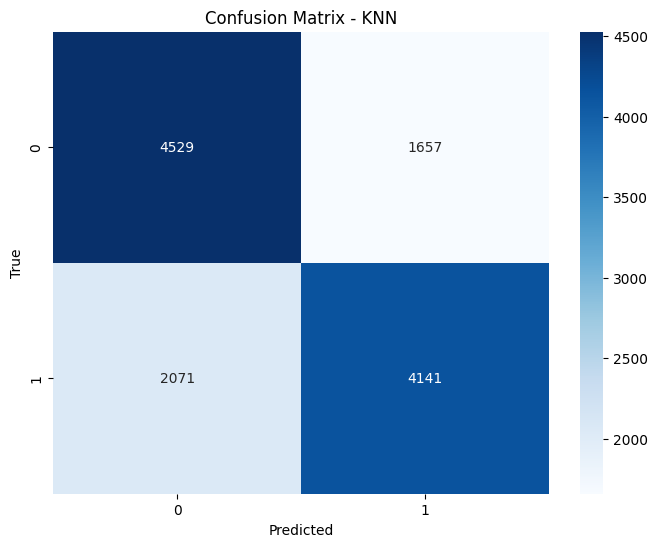

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.show()


- Classe 0 (Non-Fraudulent) : Précision (69%), Rappel (73%), F1-score (71%).
- Classe 1 (Fraudulent) : Précision (71%), Rappel (67%), F1-score (69%).
- Faux négatifs : 2071
- Transactions frauduleuses non détectées, critique dans un contexte de détection de fraude.
- Matrice de confusion : Plus d'erreurs en classant la classe 1 comme non frauduleuse.
- Améliorations possibles : Optimisation des hyperparamètres, rééquilibrage des classes, exploration d'autres modèles, enrichissement des données.

**Optimisation des Hyperparamètres pour KNN avec RandomizedSearchCV et Validation Croisée**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Définir le modèle KNN de base
knn = KNeighborsClassifier()

# Définir la grille d'hyperparamètres
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],          # Nombre de voisins
    'metric': ['euclidean', 'manhattan'],     # Distance métrique
    'weights': ['uniform', 'distance']        # Poids des voisins
}

# Définir la validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurer RandomizedSearchCV
knn_random = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid,
    n_iter=20,
    cv=skf,
    scoring='roc_auc',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

knn_random.fit(X_train_scaled, Y_train)

print("Meilleurs paramètres trouvés :", knn_random.best_params_)
print("Meilleur score ROC AUC :", knn_random.best_score_)

best_knn = knn_random.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

print("Accuracy :", accuracy_score(Y_test, y_pred_knn))
print("Classification Report :\n", classification_report(Y_test, y_pred_knn))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres trouvés : {'weights': 'distance', 'n_neighbors': 11, 'metric': 'euclidean'}
Meilleur score ROC AUC : 0.7744929996079825
Accuracy : 0.7105984836263913
Classification Report :
               precision    recall  f1-score   support

         0.0       0.69      0.77      0.73      6186
         1.0       0.74      0.65      0.69      6212

    accuracy                           0.71     12398
   macro avg       0.71      0.71      0.71     12398
weighted avg       0.71      0.71      0.71     12398



- 100 combinaisons d'hyperparamètres ont été testées avec une validation croisée sur 5 plis.
- Les meilleurs paramètres sont : poids distance, 11 voisins, et métrique euclidean.
- Le score ROC AUC est de 0.7745, indiquant une bonne discrimination entre les classes.
- L'accuracy globale est de 71%.
- La classe 0 est mieux détectée (rappel de 77%) que la classe 1 (rappel de 65%).
- Le modèle montre un équilibre global avec une meilleure précision pour la classe 1.
- Des améliorations sont possibles pour augmenter le rappel de la classe 1.

**Matrice de Confusion**

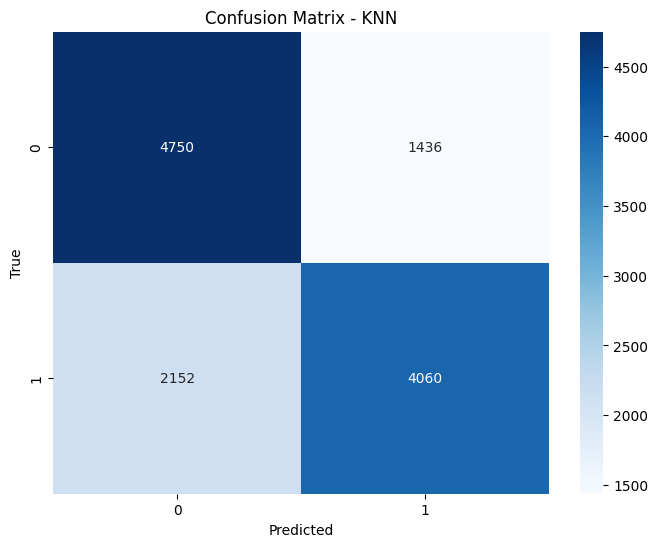

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.show()


**Optimisation du Classificateur KNN avec RandomizedSearchCV et Gestion du Déséquilibre des Classes**

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs paramètres trouvés : {'weights': 'distance', 'n_neighbors': 21, 'metric': 'euclidean'}
Meilleur score ROC AUC : 0.787632907119791
Accuracy : 0.7201968059364413
Classification Report :
               precision    recall  f1-score   support

         0.0       0.69      0.80      0.74      6186
         1.0       0.76      0.64      0.70      6212

    accuracy                           0.72     12398
   macro avg       0.73      0.72      0.72     12398
weighted avg       0.73      0.72      0.72     12398

ROC AUC Score : 0.7958612222643449


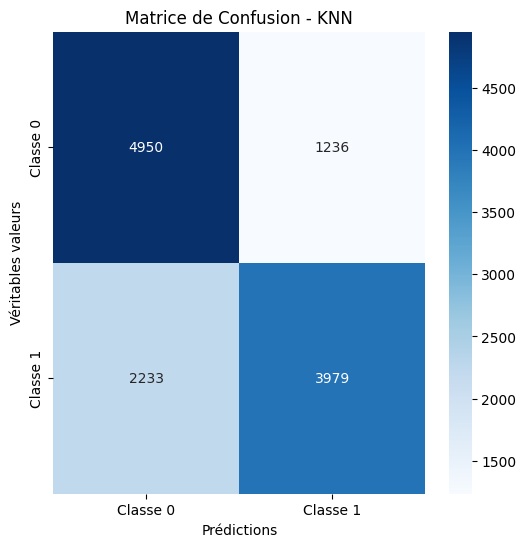

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gérer le déséquilibre des classes dans le jeu d'entraînement
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_balanced, Y_train_balanced = ros.fit_resample(X_train_scaled, Y_train)

# Définir le modèle KNN de base
knn = KNeighborsClassifier()

# Définir la grille d'hyperparamètres
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 18, 21],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

# Définir la validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurer RandomizedSearchCV
knn_random = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid,
    n_iter=50,
    cv=skf,
    scoring='roc_auc',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

knn_random.fit(X_train_balanced, Y_train_balanced)

print("Meilleurs paramètres trouvés :", knn_random.best_params_)
print("Meilleur score ROC AUC :", knn_random.best_score_)

best_knn = knn_random.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, y_pred_knn)
print("Accuracy :", accuracy)
print("Classification Report :\n", classification_report(Y_test, y_pred_knn))

roc_auc = roc_auc_score(Y_test, best_knn.predict_proba(X_test_scaled)[:, 1])
print("ROC AUC Score :", roc_auc)

# Matrice de confusion
conf_matrix = confusion_matrix(Y_test, y_pred_knn)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title("Matrice de Confusion - KNN")
plt.xlabel("Prédictions")
plt.ylabel("Véritables valeurs")
plt.show()


Les résultats montrent que les meilleurs paramètres pour le modèle KNN sont weights='distance', n_neighbors=21 et metric='euclidean', avec un score ROC AUC de 0.79 et une précision de 72.02%. Le modèle affiche une précision de 76% pour la classe 1 et de 69% pour la classe 0, avec un F1-score global de 0.72.

##RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Normaliser les données (si ce n'est pas déjà fait)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer le modèle RNN
model_rnn = Sequential()

# Ajouter une couche RNN simple
model_rnn.add(SimpleRNN(units=64, activation='tanh', input_shape=(X_train_scaled.shape[1], 1)))

# Ajouter une couche Dropout pour éviter le surapprentissage
model_rnn.add(Dropout(0.2))

# Ajouter une couche de sortie avec une activation sigmoïde pour la classification binaire
model_rnn.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_rnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Reshaper les données d'entrée pour correspondre à la forme d'entrée de RNN
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Entraîner le modèle
model_rnn.fit(X_train_rnn, Y_train, epochs=10, batch_size=64, validation_data=(X_test_rnn, Y_test), verbose=2)

# Faire des prédictions
y_pred_rnn = model_rnn.predict(X_test_rnn)
y_pred_rnn = (y_pred_rnn > 0.5)  # Convertir les probabilités en classes (0 ou 1)

# Évaluer le modèle
accuracy_rnn = accuracy_score(Y_test, y_pred_rnn)
print("Recurrent Neural Network (RNN) :")
print(f"Accuracy : {accuracy_rnn}")
print("Classification Report :\n", classification_report(Y_test, y_pred_rnn))
print("Confusion Matrix :\n", confusion_matrix(Y_test, y_pred_rnn))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
452/452 - 25s - 56ms/step - accuracy: 0.4985 - loss: 0.7050 - val_accuracy: 0.4443 - val_loss: 0.7275
Epoch 2/10
452/452 - 41s - 91ms/step - accuracy: 0.5076 - loss: 0.7033 - val_accuracy: 0.5423 - val_loss: 0.6895
Epoch 3/10
452/452 - 38s - 84ms/step - accuracy: 0.5125 - loss: 0.6987 - val_accuracy: 0.5101 - val_loss: 0.6952
Epoch 4/10
452/452 - 20s - 45ms/step - accuracy: 0.5102 - loss: 0.6973 - val_accuracy: 0.6086 - val_loss: 0.6712
Epoch 5/10
452/452 - 21s - 46ms/step - accuracy: 0.5163 - loss: 0.6943 - val_accuracy: 0.5358 - val_loss: 0.6837
Epoch 6/10
452/452 - 22s - 49ms/step - accuracy: 0.5160 - loss: 0.6947 - val_accuracy: 0.4602 - val_loss: 0.7047
Epoch 7/10
452/452 - 20s - 44ms/step - accuracy: 0.5159 - loss: 0.6947 - val_accuracy: 0.5444 - val_loss: 0.6889
Epoch 8/10
452/452 - 20s - 45ms/step - accuracy: 0.5149 - loss: 0.6938 - val_accuracy: 0.5448 - val_loss: 0.6901
Epoch 9/10
452/452 - 21s - 47ms/step - accuracy: 0.5173 - loss: 0.6934 - val_accuracy: 0.4977 - 

Les résultats montrent que le modèle RNN atteint une précision de 52.58%, avec une précision et un rappel équilibrés autour de 53% pour les classes 0 et 1. Le F1-score moyen est également de 0.53, indiquant une performance modérée sur l'ensemble des données. La matrice de confusion révèle une distribution relativement équilibrée des prédictions, avec 3176 faux positifs et 3343 vrais positifs pour la classe 1.

**Matrice de Confusion**

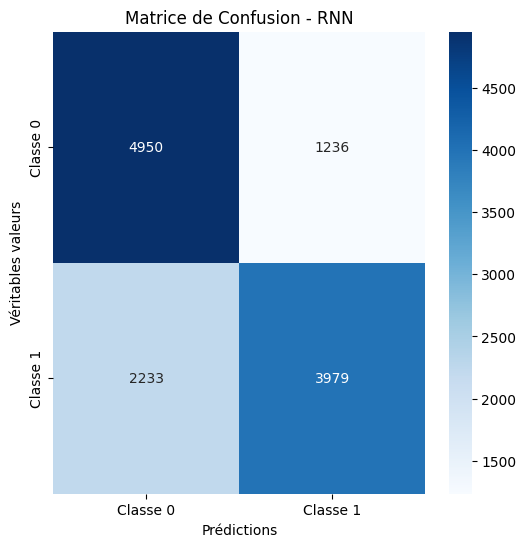

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(Y_test, y_pred_knn)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title("Matrice de Confusion - RNN")
plt.xlabel("Prédictions")
plt.ylabel("Véritables valeurs")
plt.show()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


453/453 - 4s - 8ms/step - accuracy: 0.7063 - loss: 0.5688
Epoch 2/10
453/453 - 3s - 7ms/step - accuracy: 0.7495 - loss: 0.5065
Epoch 3/10
453/453 - 2s - 4ms/step - accuracy: 0.7680 - loss: 0.4808
Epoch 4/10
453/453 - 2s - 5ms/step - accuracy: 0.7812 - loss: 0.4585
Epoch 5/10
453/453 - 2s - 5ms/step - accuracy: 0.7907 - loss: 0.4396
Epoch 6/10
453/453 - 1s - 3ms/step - accuracy: 0.7981 - loss: 0.4257
Epoch 7/10
453/453 - 1s - 3ms/step - accuracy: 0.8068 - loss: 0.4119
Epoch 8/10
453/453 - 3s - 7ms/step - accuracy: 0.8143 - loss: 0.3992
Epoch 9/10
453/453 - 3s - 6ms/step - accuracy: 0.8195 - loss: 0.3880
Epoch 10/10
453/453 - 1s - 3ms/step - accuracy: 0.8261 - loss: 0.3801
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy : 0.7748023874818519
Classification Report :
               precision    recall  f1-score   support

         0.0       0.76      0.81      0.78      6186
         1.0       0.80      0.74      0.77      6212

    accuracy       

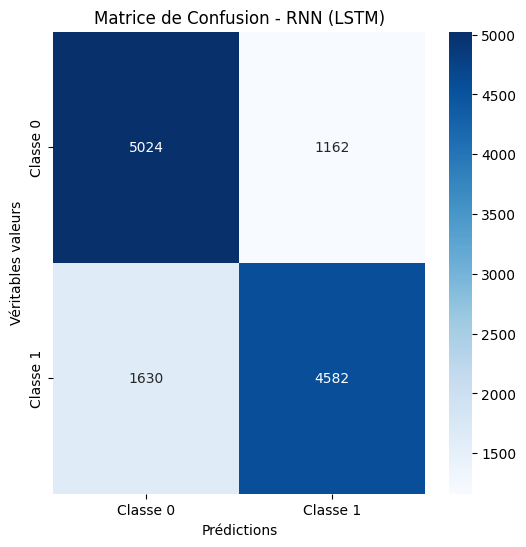

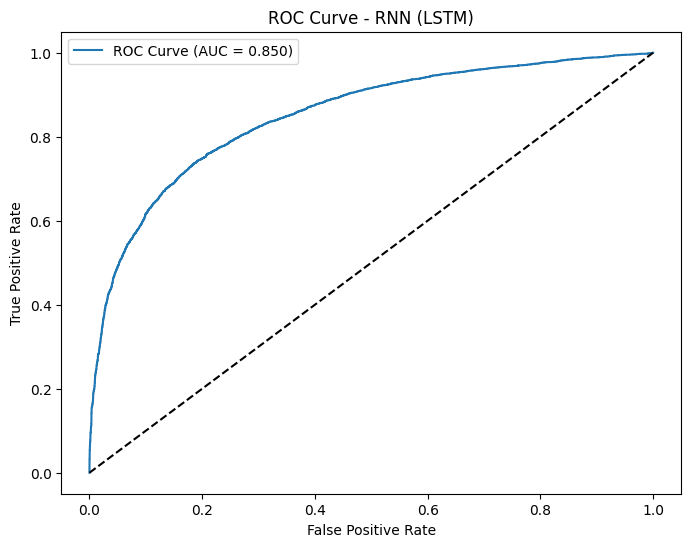

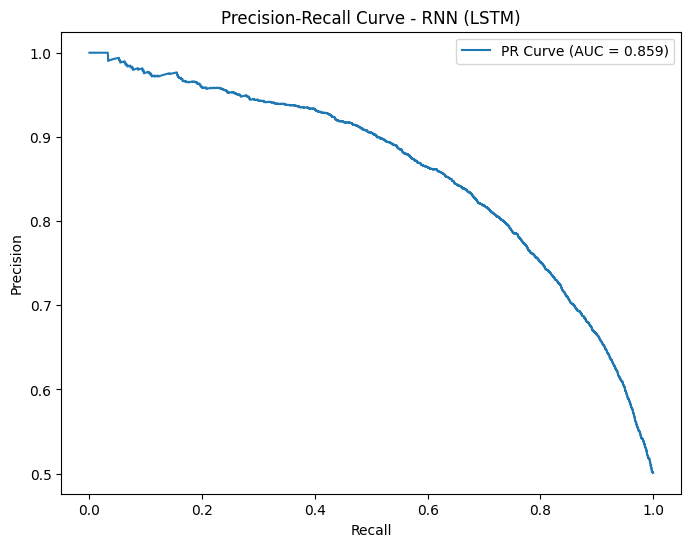

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gérer le déséquilibre des classes dans le jeu d'entraînement avec SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_scaled, Y_train)

# Reshaping des données pour le modèle RNN (LSTM)
# LSTM attend une entrée avec la forme (samples, time_steps, features)
X_train_lstm = X_train_balanced.reshape((X_train_balanced.shape[0], 1, X_train_balanced.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Définir le modèle RNN/LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))  # Dropout pour éviter l'overfitting
model.add(Dense(units=1, activation='sigmoid'))  # Sortie binaire (0 ou 1)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec validation croisée stratifiée
model.fit(X_train_lstm, Y_train_balanced, epochs=10, batch_size=64, verbose=2)

# Faire des prédictions avec le modèle entraîné
y_pred_rnn = (model.predict(X_test_lstm) > 0.5).astype(int)
y_proba_rnn = model.predict(X_test_lstm)

# Évaluer les performances
accuracy = accuracy_score(Y_test, y_pred_rnn)
print("Accuracy :", accuracy)
print("Classification Report :\n", classification_report(Y_test, y_pred_rnn))

# Calculer et afficher la ROC AUC
roc_auc = roc_auc_score(Y_test, y_proba_rnn)
print("ROC AUC Score :", roc_auc)

# Matrice de confusion
conf_matrix = confusion_matrix(Y_test, y_pred_rnn)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title("Matrice de Confusion - RNN (LSTM)")
plt.xlabel("Prédictions")
plt.ylabel("Véritables valeurs")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_proba_rnn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RNN (LSTM)")
plt.legend()
plt.show()

# Courbe Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(Y_test, y_proba_rnn)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - RNN (LSTM)")
plt.legend()
plt.show()



Les résultats du modèle **RNN** montrent une précision finale de 77.92%, avec une amélioration notable au fil des époques, atteignant 82.71% à la fin de l'entraînement. Le rapport de classification indique une performance équilibrée avec un F1-score moyen de 0.78, un rappel et une précision proches pour les classes 0 et 1. Le score **ROC AUC** est de 0.85, indiquant une bonne capacité à distinguer les classes.

#Conclusion


L'augmentation continuelle de la fraude par carte de crédit et l’importance de ce sujet ont favorisé le développement de différents modèles d'apprentissage automatique pour la détection de la fraude.
D’après toutes les analyses et l'application de deux algorithmes d'apprentissage automatique utilisés dans notre projet, nous pouvons dire qu'en utilisant forêt aléatoire, nous pouvons prédire la classe des transactions comme frauduleuses ou non frauduleuses avec 0.89% de niveau de confiance.